<a href="https://colab.research.google.com/github/gerdac/instance_segmentation_thermal/blob/main/Sensitivity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2


<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 3.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15303, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 15303 (delta 9), reused 12 (delta 1), pack-reused 15275
Receiving objects: 100% (15303/15303), 6.18 MiB | 17.30 MiB/s, done.
Resolving deltas: 100% (11120/11120), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 843.7 kB/s eta 0:00:00
  

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


## Some basic setup

In [1]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

ModuleNotFoundError: No module named 'detectron2'

In [2]:
# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import utilities for visualization
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

In [3]:
!pip install sensitivity
from sensitivity import SensitivityAnalyzer
# https://nickderobertis.github.io/sensitivity/tutorial.html#install
# https://nickderobertis.github.io/sensitivity/auto_examples/sensitivity_analysis.html

# ??? ANOTHER SENSITIVITY ANALYSIS OPTION https://colab.research.google.com/github/Xifus/SA-lab/blob/master/Sensitivity_Analysis_Lab.ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.6 MB/s eta 0:00:00


# Formulas

## U-value windows

In [ ]:
def uvalue_win_calc(t_ic, t_ec, t_ie, t_ee, t_if, t_ef, a_c, a_e, a_f, h = bool):
  h_ensav = 9.09
  h_stand = 7.69

  t_it = t_ic + t_ie + t_if
  t_et = t_ec + t_ee + t_ef

  a_t = a_c + a_e + a_f

  w = t_it - t_et #total
  x = t_ic - t_ec #center
  y = t_ie - t_ee #edge
  z = t_if - t_ef #frame

  if h == 1:
    h = h_ensav
  else:
    h = h_stand

  u_c = h*x/w
  u_e = h*y/w
  u_f = h*z/w

  u_win_t = (u_c*a_c + u_e*a_e + u_f*a_f)/a_t

  return u_win_t

In [ ]:
uvalue_win_calc(16, 4, 16, 4, 16, 4, 75, 12.5, 12.5)

In [4]:
h_ensav = 9.09
h_stand = 7.69

def uvalue_win_calc(t_ic, t_ec, t_ie, t_ee, t_if, t_ef, a_c, a_e = None, a_f = None, h = bool):
  t_it = t_ic + t_ie + t_if
  t_et = t_ec + t_ee + t_ef

  if a_e == None and a_f == None:
    a_e = (100 - a_c)/2
    a_f = a_e
  elif a_e == None:
    a_e = 100 - a_f
  else:
    a_f = 100 - a_e


  a_t = a_c + a_e + a_f

  w = t_it - t_et #total
  x = t_ic - t_ec #center
  y = t_ie - t_ee #edge
  z = t_if - t_ef #frame

  if h == 1:
    h = h_ensav
  else:
    h = h_stand

  u_c = h*x/w
  u_e = h*y/w
  u_f = h*z/w

  u_win_t = (u_c*a_c + u_e*a_e + u_f*a_f)/a_t

  return u_win_t


In [5]:
uvalue_win_calc(16, 4, 16, 4, 16, 4, 75)

2.563333333333334

### Sensitivity Analysis

100%|██████████| 19683/19683 [00:29<00:00, 661.14it/s]


,5,7,9
t_ic,,,
18,2.574787,2.401421,2.207979
20,2.731067,2.574787,2.401421
22,2.872683,2.731067,2.574787


,18,20,22
t_ic,,,
18,2.474495,2.391857,2.317836
20,2.653854,2.566197,2.487225
22,2.814558,2.723309,2.640671


,5,7,9
t_ic,,,
18,2.317836,2.391857,2.474495
20,2.487225,2.566197,2.653854
22,2.640671,2.723309,2.814558


,18,20,22
t_ic,,,
18,2.474495,2.391857,2.317836
20,2.653854,2.566197,2.487225
22,2.814558,2.723309,2.640671


,5,7,9
t_ic,,,
18,2.317836,2.391857,2.474495
20,2.487225,2.566197,2.653854
22,2.640671,2.723309,2.814558


,70,75,80
t_ic,,,
18,2.399860,2.394561,2.389766
20,2.568917,2.569098,2.569261
22,2.721223,2.726341,2.730972


,10.000000,12.500000,15.000000
t_ic,,,
18,2.387064,2.394856,2.402268
20,2.569354,2.569087,2.568834
22,2.733583,2.726056,2.718898


,10.000000,12.500000,15.000000
t_ic,,,
18,2.387064,2.394856,2.402268
20,2.569354,2.569087,2.568834
22,2.733583,2.726056,2.718898


,18,20,22
t_ec,,,
5,2.814558,2.723309,2.640671
7,2.653854,2.566197,2.487225
9,2.474495,2.391857,2.317836


,5,7,9
t_ec,,,
5,2.640671,2.723309,2.814558
7,2.487225,2.566197,2.653854
9,2.317836,2.391857,2.474495


,18,20,22
t_ec,,,
5,2.814558,2.723309,2.640671
7,2.653854,2.566197,2.487225
9,2.474495,2.391857,2.317836


,5,7,9
t_ec,,,
5,2.640671,2.723309,2.814558
7,2.487225,2.566197,2.653854
9,2.317836,2.391857,2.474495


,70,75,80
t_ec,,,
5,2.721223,2.726341,2.730972
7,2.568917,2.569098,2.569261
9,2.399860,2.394561,2.389766


,10.000000,12.500000,15.000000
t_ec,,,
5,2.733583,2.726056,2.718898
7,2.569354,2.569087,2.568834
9,2.387064,2.394856,2.402268


,10.000000,12.500000,15.000000
t_ec,,,
5,2.733583,2.726056,2.718898
7,2.569354,2.569087,2.568834
9,2.387064,2.394856,2.402268


,5,7,9
t_ie,,,
18,2.557607,2.644289,2.741010
20,2.479466,2.557607,2.644289
22,2.408658,2.479466,2.557607


,18,20,22
t_ie,,,
18,2.741010,2.644289,2.557607
20,2.644289,2.557607,2.479466
22,2.557607,2.479466,2.408658


,5,7,9
t_ie,,,
18,2.557607,2.644289,2.741010
20,2.479466,2.557607,2.644289
22,2.408658,2.479466,2.557607


,70,75,80
t_ie,,,
18,2.645070,2.647719,2.650117
20,2.560542,2.560451,2.560369
22,2.484388,2.481829,2.479514


,10.000000,12.500000,15.000000
t_ie,,,
18,2.656576,2.647487,2.638844
20,2.560149,2.560459,2.560754
22,2.473276,2.482054,2.490402


,10.000000,12.500000,15.000000
t_ie,,,
18,2.646361,2.647657,2.648889
20,2.560498,2.560453,2.560411
22,2.483142,2.481890,2.480700


,18,20,22
t_ee,,,
5,2.557607,2.479466,2.408658
7,2.644289,2.557607,2.479466
9,2.741010,2.644289,2.557607


,5,7,9
t_ee,,,
5,2.408658,2.479466,2.557607
7,2.479466,2.557607,2.644289
9,2.557607,2.644289,2.741010


,70,75,80
t_ee,,,
5,2.484388,2.481829,2.479514
7,2.560542,2.560451,2.560369
9,2.645070,2.647719,2.650117


,10.000000,12.500000,15.000000
t_ee,,,
5,2.473276,2.482054,2.490402
7,2.560149,2.560459,2.560754
9,2.656576,2.647487,2.638844


,10.000000,12.500000,15.000000
t_ee,,,
5,2.483142,2.481890,2.480700
7,2.560498,2.560453,2.560411
9,2.646361,2.647657,2.648889


,5,7,9
t_if,,,
18,2.557607,2.644289,2.741010
20,2.479466,2.557607,2.644289
22,2.408658,2.479466,2.557607


,70,75,80
t_if,,,
18,2.645070,2.647719,2.650117
20,2.560542,2.560451,2.560369
22,2.484388,2.481829,2.479514


,10.000000,12.500000,15.000000
t_if,,,
18,2.646361,2.647657,2.648889
20,2.560498,2.560453,2.560411
22,2.483142,2.481890,2.480700


,10.000000,12.500000,15.000000
t_if,,,
18,2.656576,2.647487,2.638844
20,2.560149,2.560459,2.560754
22,2.473276,2.482054,2.490402


,70,75,80
t_ef,,,
5,2.484388,2.481829,2.479514
7,2.560542,2.560451,2.560369
9,2.645070,2.647719,2.650117


,10.000000,12.500000,15.000000
t_ef,,,
5,2.483142,2.481890,2.480700
7,2.560498,2.560453,2.560411
9,2.646361,2.647657,2.648889


,10.000000,12.500000,15.000000
t_ef,,,
5,2.473276,2.482054,2.490402
7,2.560149,2.560459,2.560754
9,2.656576,2.647487,2.638844


,10.000000,12.500000,15.000000
a_c,,,
70,2.563333,2.563333,2.563333
75,2.563333,2.563333,2.563333
80,2.563333,2.563333,2.563333


,10.000000,12.500000,15.000000
a_c,,,
70,2.563333,2.563333,2.563333
75,2.563333,2.563333,2.563333
80,2.563333,2.563333,2.563333


,10.000000,12.500000,15.000000
a_e,,,
10.000000,2.563333,2.563333,2.563333
12.500000,2.563333,2.563333,2.563333
15.000000,2.563333,2.563333,2.563333


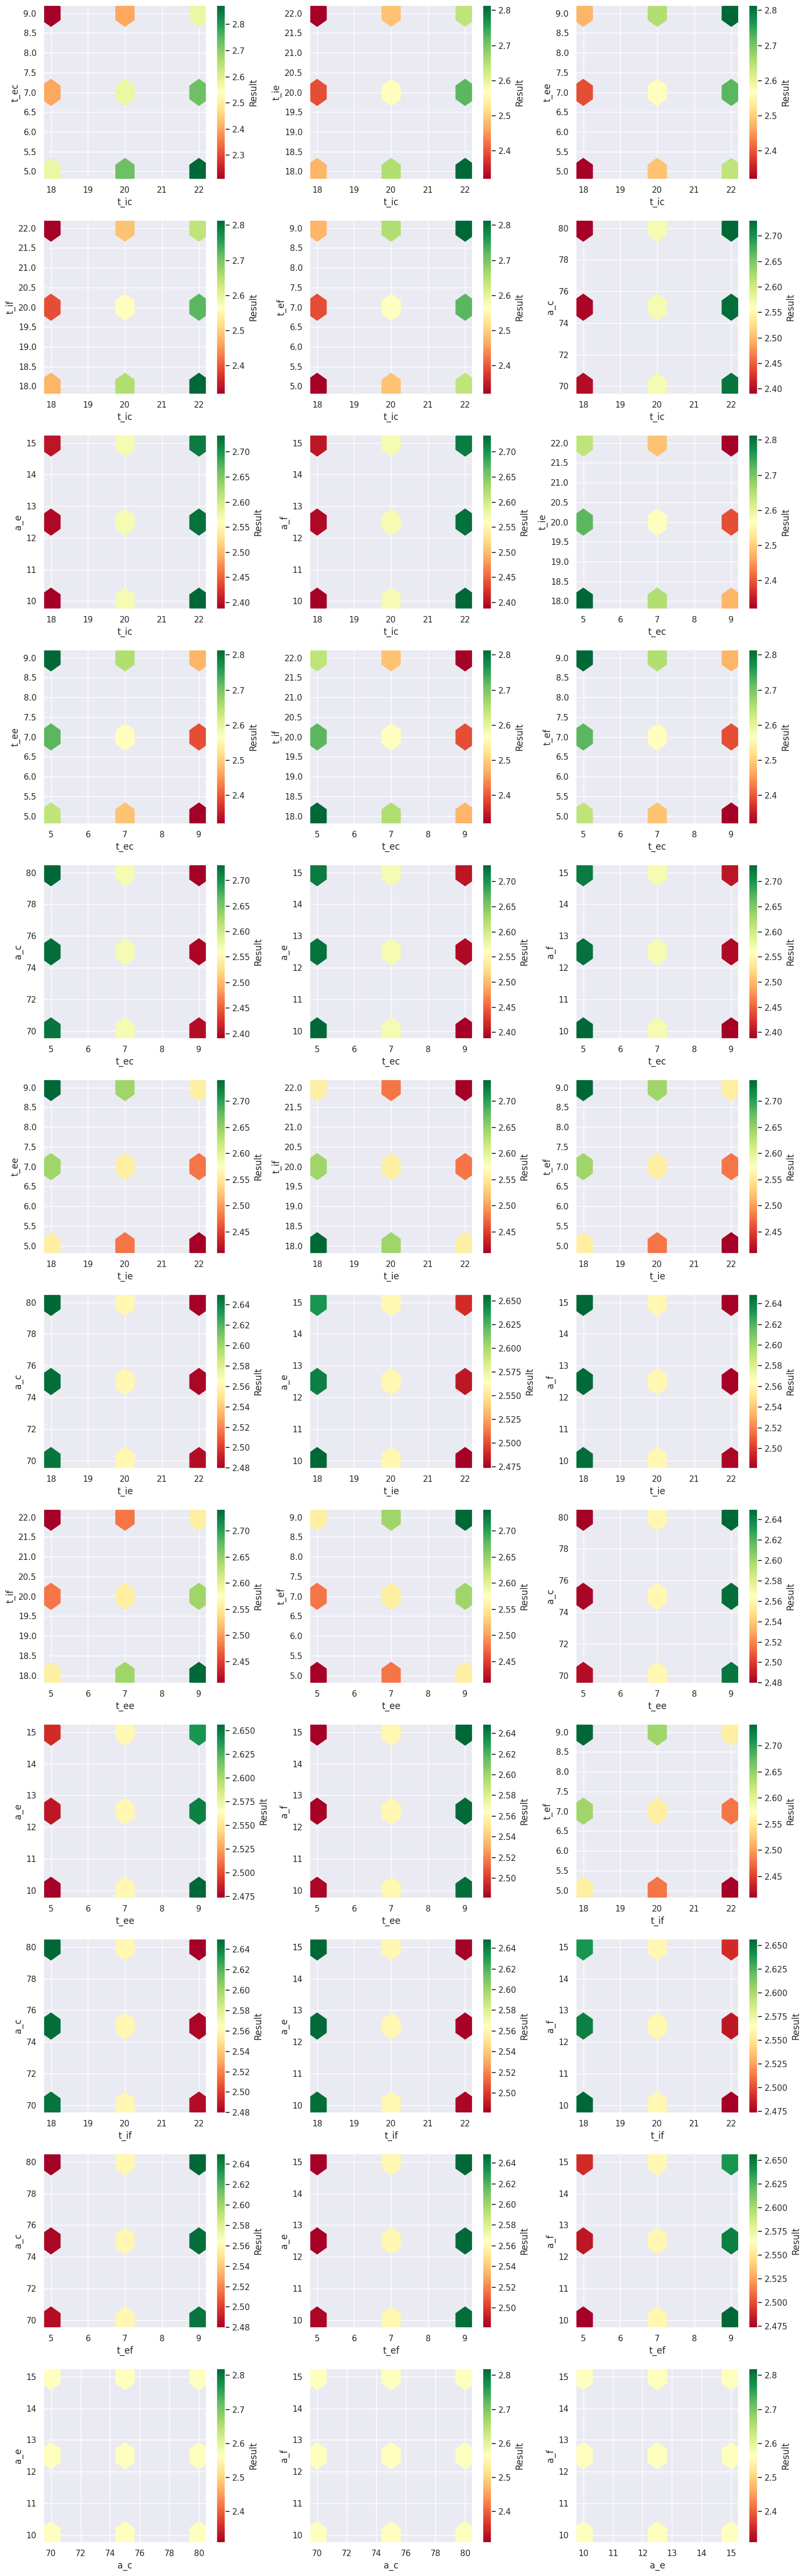

In [ ]:
sensitivity_dict_win = {
    't_ic' : [ 18, 20, 22 ],
    't_ec' : [ 5, 7, 9 ],
    't_ie' : [ 18, 20, 22 ],
    't_ee' : [ 5, 7, 9 ],
    't_if' : [ 18, 20, 22 ],
    't_ef' : [ 5, 7, 9 ],
    'a_c' : [ 70, 75, 80 ],
    'a_e' : [ 15, 12.5, 10 ],
    'a_f' : [ 15, 12.5, 10 ],
}

sa_u_win = SensitivityAnalyzer(sensitivity_dict_win, uvalue_win_calc)

plot = sa_u_win.plot()

styled_dict = sa_u_win.styled_dfs()

100%|██████████| 78125/78125 [02:21<00:00, 554.00it/s]


,3,5,7,9,11
t_ic,,,,,
16,2.599113,2.425843,2.231953,2.013393,1.764930
18,2.754954,2.599113,2.425843,2.231953,2.013393
20,2.895917,2.754954,2.599113,2.425843,2.231953
22,3.024071,2.895917,2.754954,2.599113,2.425843
24,3.141112,3.024071,2.895917,2.754954,2.599113


,16,18,20,22,24
t_ic,,,,,
16,2.363732,2.275542,2.198110,2.129526,2.068320
18,2.576154,2.480488,2.395816,2.320299,2.252498
20,2.762867,2.662105,2.572278,2.491658,2.418871
22,2.928395,2.824257,2.730819,2.646479,2.569948
24,3.076236,2.969979,2.874087,2.787087,2.707778


,3,5,7,9,11
t_ic,,,,,
16,2.068320,2.129526,2.198110,2.275542,2.363732
18,2.252498,2.320299,2.395816,2.480488,2.576154
20,2.418871,2.491658,2.572278,2.662105,2.762867
22,2.569948,2.646479,2.730819,2.824257,2.928395
24,2.707778,2.787087,2.874087,2.969979,3.076236


,16,18,20,22,24
t_ic,,,,,
16,2.363732,2.275542,2.198110,2.129526,2.068320
18,2.576154,2.480488,2.395816,2.320299,2.252498
20,2.762867,2.662105,2.572278,2.491658,2.418871
22,2.928395,2.824257,2.730819,2.646479,2.569948
24,3.076236,2.969979,2.874087,2.787087,2.707778


,3,5,7,9,11
t_ic,,,,,
16,2.068320,2.129526,2.198110,2.275542,2.363732
18,2.252498,2.320299,2.395816,2.480488,2.576154
20,2.418871,2.491658,2.572278,2.662105,2.762867
22,2.569948,2.646479,2.730819,2.824257,2.928395
24,2.707778,2.787087,2.874087,2.969979,3.076236


,65,70,75,80,85
t_ic,,,,,
16,2.292555,2.249801,2.207046,2.164292,2.121537
18,2.443039,2.424045,2.405051,2.386057,2.367063
20,2.577183,2.579369,2.581556,2.583743,2.585929
22,2.697585,2.718782,2.739980,2.761177,2.782375
24,2.806306,2.844670,2.883034,2.921398,2.959762


,16,18,20,22,24
t_ec,,,,,
3,3.076236,2.969979,2.874087,2.787087,2.707778
5,2.928395,2.824257,2.730819,2.646479,2.569948
7,2.762867,2.662105,2.572278,2.491658,2.418871
9,2.576154,2.480488,2.395816,2.320299,2.252498
11,2.363732,2.275542,2.198110,2.129526,2.068320


,3,5,7,9,11
t_ec,,,,,
3,2.707778,2.787087,2.874087,2.969979,3.076236
5,2.569948,2.646479,2.730819,2.824257,2.928395
7,2.418871,2.491658,2.572278,2.662105,2.762867
9,2.252498,2.320299,2.395816,2.480488,2.576154
11,2.068320,2.129526,2.198110,2.275542,2.363732


,16,18,20,22,24
t_ec,,,,,
3,3.076236,2.969979,2.874087,2.787087,2.707778
5,2.928395,2.824257,2.730819,2.646479,2.569948
7,2.762867,2.662105,2.572278,2.491658,2.418871
9,2.576154,2.480488,2.395816,2.320299,2.252498
11,2.363732,2.275542,2.198110,2.129526,2.068320


,3,5,7,9,11
t_ec,,,,,
3,2.707778,2.787087,2.874087,2.969979,3.076236
5,2.569948,2.646479,2.730819,2.824257,2.928395
7,2.418871,2.491658,2.572278,2.662105,2.762867
9,2.252498,2.320299,2.395816,2.480488,2.576154
11,2.068320,2.129526,2.198110,2.275542,2.363732


,65,70,75,80,85
t_ec,,,,,
3,2.806306,2.844670,2.883034,2.921398,2.959762
5,2.697585,2.718782,2.739980,2.761177,2.782375
7,2.577183,2.579369,2.581556,2.583743,2.585929
9,2.443039,2.424045,2.405051,2.386057,2.367063
11,2.292555,2.249801,2.207046,2.164292,2.121537


,3,5,7,9,11
t_ie,,,,,
16,2.545443,2.632079,2.729024,2.838304,2.962535
18,2.467523,2.545443,2.632079,2.729024,2.838304
20,2.397041,2.467523,2.545443,2.632079,2.729024
22,2.332964,2.397041,2.467523,2.545443,2.632079
24,2.274444,2.332964,2.397041,2.467523,2.545443


,16,18,20,22,24
t_ie,,,,,
16,2.962535,2.838304,2.729024,2.632079,2.545443
18,2.838304,2.729024,2.632079,2.545443,2.467523
20,2.729024,2.632079,2.545443,2.467523,2.397041
22,2.632079,2.545443,2.467523,2.397041,2.332964
24,2.545443,2.467523,2.397041,2.332964,2.274444


,3,5,7,9,11
t_ie,,,,,
16,2.545443,2.632079,2.729024,2.838304,2.962535
18,2.467523,2.545443,2.632079,2.729024,2.838304
20,2.397041,2.467523,2.545443,2.632079,2.729024
22,2.332964,2.397041,2.467523,2.545443,2.632079
24,2.274444,2.332964,2.397041,2.467523,2.545443


,65,70,75,80,85
t_ie,,,,,
16,2.698722,2.720100,2.741477,2.762854,2.784231
18,2.623481,2.632978,2.642474,2.651971,2.661468
20,2.556409,2.555315,2.554222,2.553129,2.552035
22,2.496208,2.485609,2.475010,2.464411,2.453813
24,2.441847,2.422665,2.403483,2.384301,2.365119


,16,18,20,22,24
t_ee,,,,,
3,2.545443,2.467523,2.397041,2.332964,2.274444
5,2.632079,2.545443,2.467523,2.397041,2.332964
7,2.729024,2.632079,2.545443,2.467523,2.397041
9,2.838304,2.729024,2.632079,2.545443,2.467523
11,2.962535,2.838304,2.729024,2.632079,2.545443


,3,5,7,9,11
t_ee,,,,,
3,2.274444,2.332964,2.397041,2.467523,2.545443
5,2.332964,2.397041,2.467523,2.545443,2.632079
7,2.397041,2.467523,2.545443,2.632079,2.729024
9,2.467523,2.545443,2.632079,2.729024,2.838304
11,2.545443,2.632079,2.729024,2.838304,2.962535


,65,70,75,80,85
t_ee,,,,,
3,2.441847,2.422665,2.403483,2.384301,2.365119
5,2.496208,2.485609,2.475010,2.464411,2.453813
7,2.556409,2.555315,2.554222,2.553129,2.552035
9,2.623481,2.632978,2.642474,2.651971,2.661468
11,2.698722,2.720100,2.741477,2.762854,2.784231


,3,5,7,9,11
t_if,,,,,
16,2.545443,2.632079,2.729024,2.838304,2.962535
18,2.467523,2.545443,2.632079,2.729024,2.838304
20,2.397041,2.467523,2.545443,2.632079,2.729024
22,2.332964,2.397041,2.467523,2.545443,2.632079
24,2.274444,2.332964,2.397041,2.467523,2.545443


,65,70,75,80,85
t_if,,,,,
16,2.698722,2.720100,2.741477,2.762854,2.784231
18,2.623481,2.632978,2.642474,2.651971,2.661468
20,2.556409,2.555315,2.554222,2.553129,2.552035
22,2.496208,2.485609,2.475010,2.464411,2.453813
24,2.441847,2.422665,2.403483,2.384301,2.365119


,65,70,75,80,85
t_ef,,,,,
3,2.441847,2.422665,2.403483,2.384301,2.365119
5,2.496208,2.485609,2.475010,2.464411,2.453813
7,2.556409,2.555315,2.554222,2.553129,2.552035
9,2.623481,2.632978,2.642474,2.651971,2.661468
11,2.698722,2.720100,2.741477,2.762854,2.784231


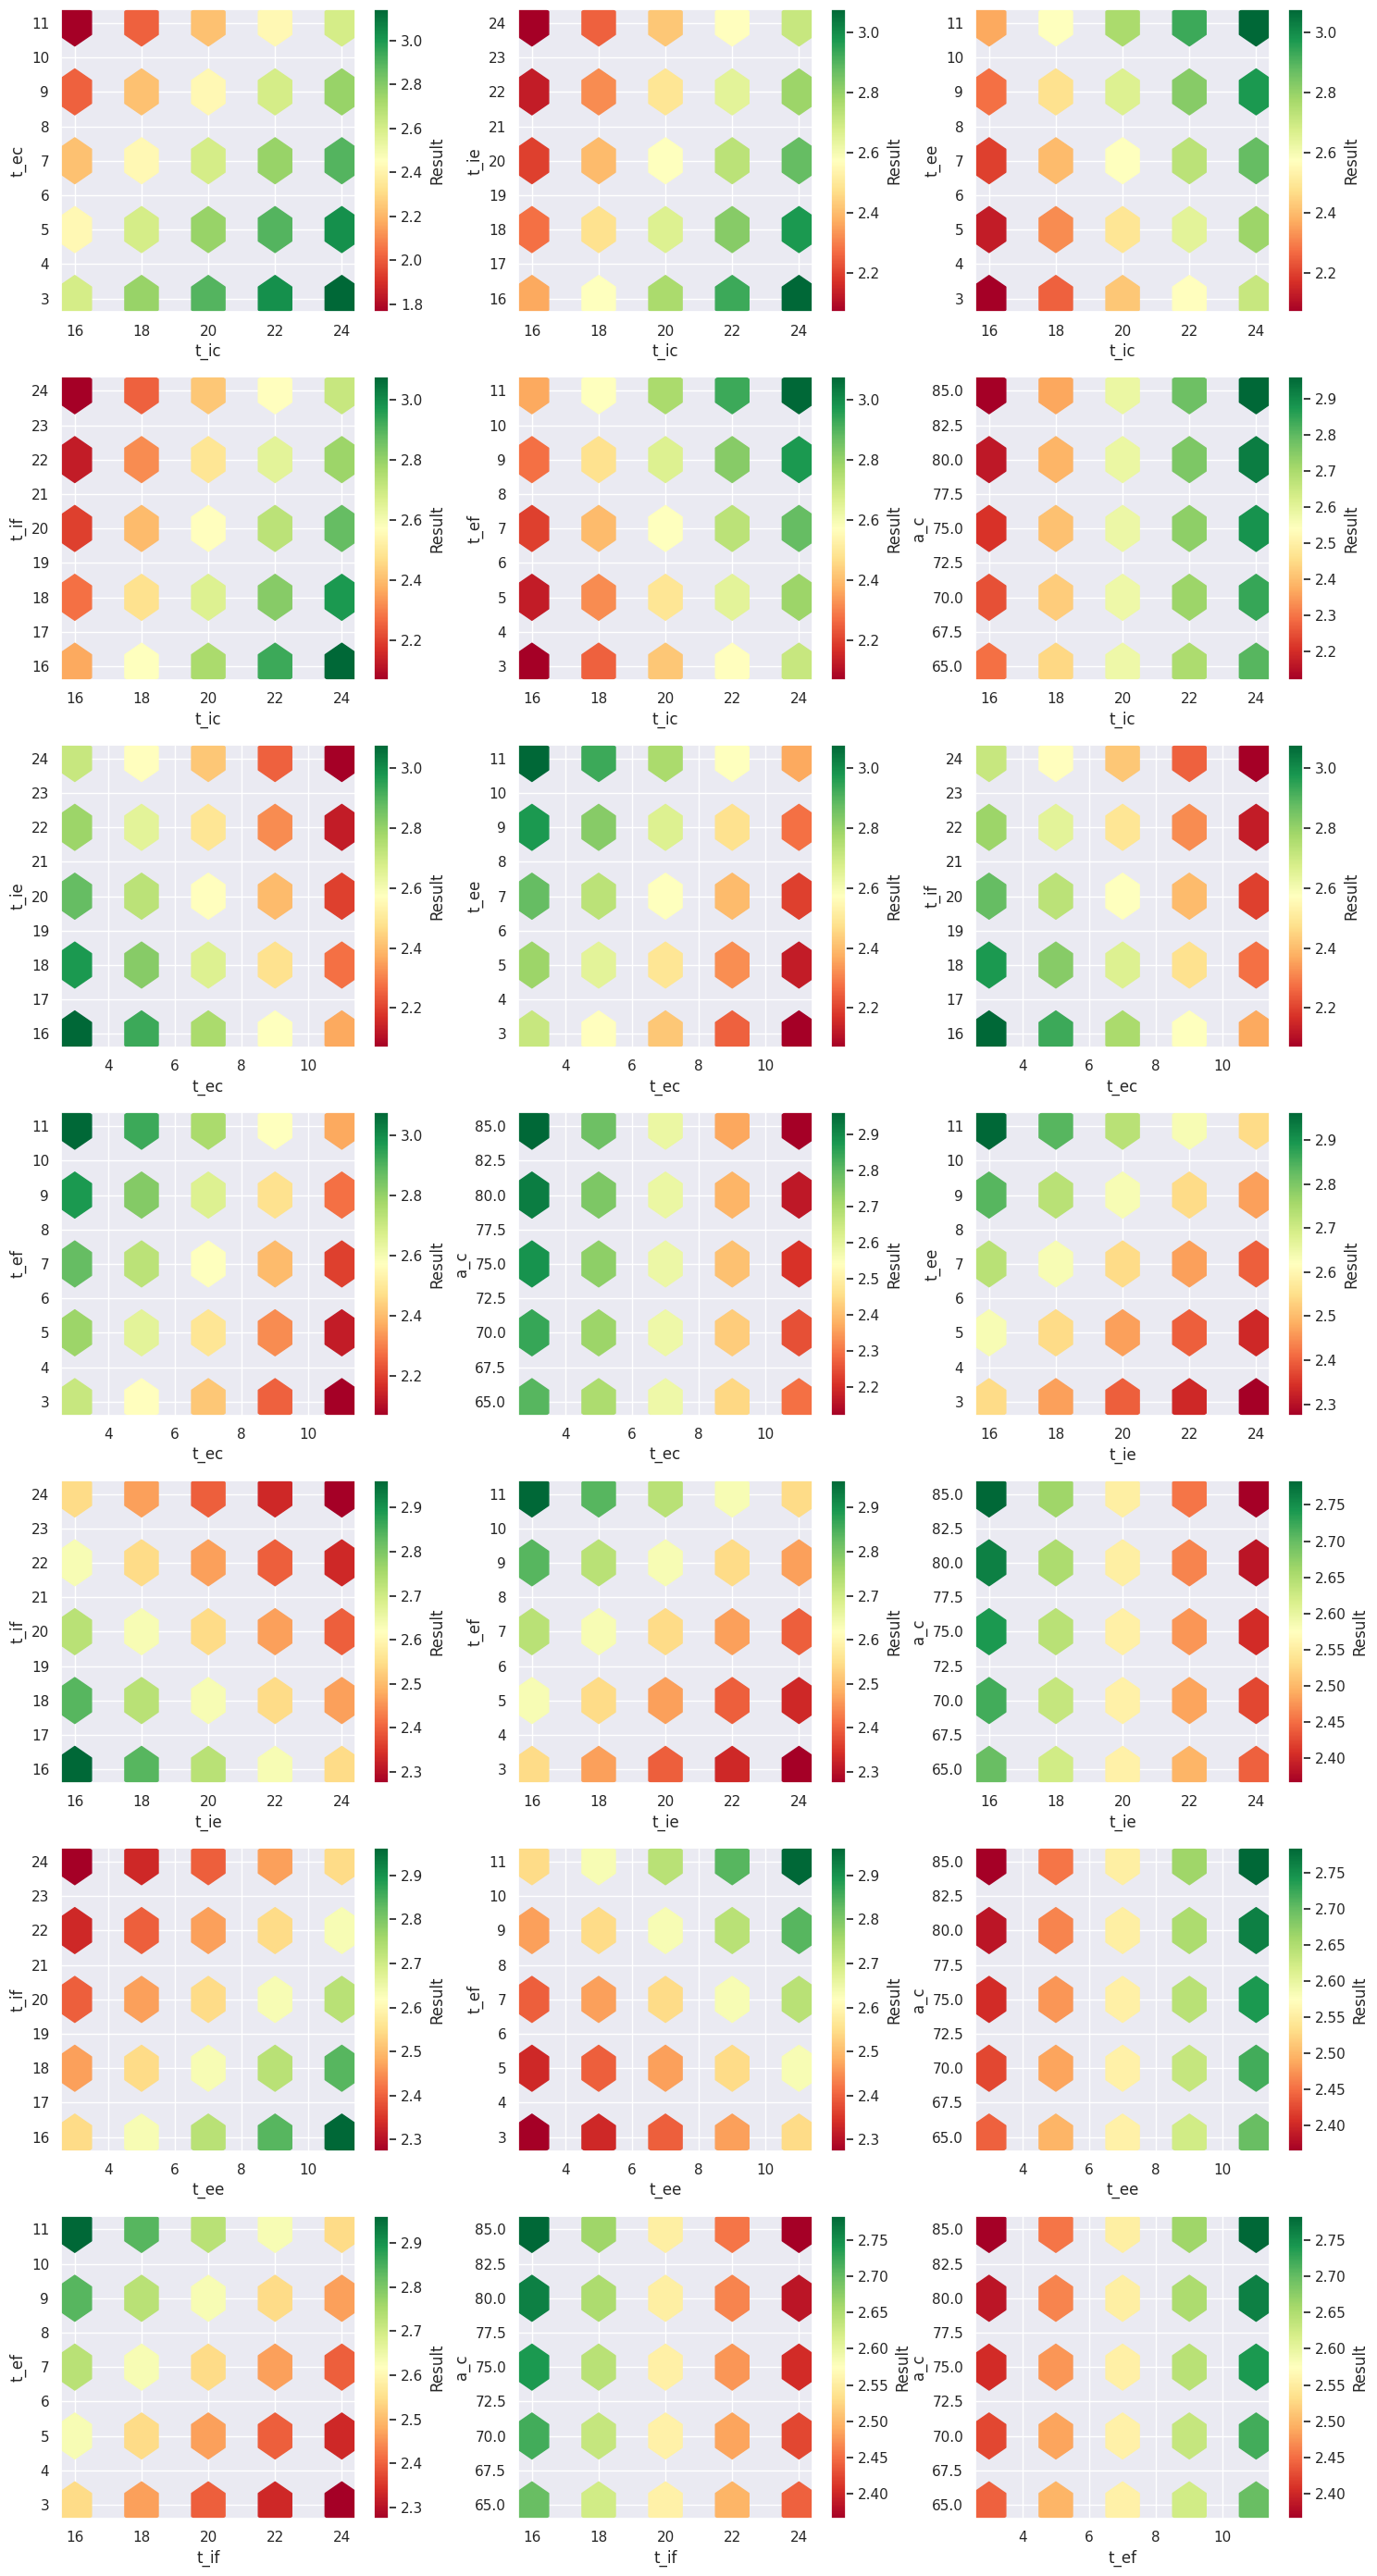

In [ ]:
sensitivity_dict_win = {
    't_ic' : [ 16, 18, 20, 22, 24 ],
    't_ec' : [ 3, 5, 7, 9, 11 ],
    't_ie' : [ 16, 18, 20, 22, 24 ],
    't_ee' : [ 3, 5, 7, 9, 11 ],
    't_if' : [ 16, 18, 20, 22, 24 ],
    't_ef' : [ 3, 5, 7, 9, 11 ],
    'a_c' : [ 65, 70, 75, 80, 85 ],
    # 'a_e' : [ 17.5, 15, 12.5, 10, 7.5 ],
    # 'a_f' : [ 17.5, 15, 12.5, 10, 7.5 ],
}

sa_u_win = SensitivityAnalyzer(sensitivity_dict_win, uvalue_win_calc)

plot = sa_u_win.plot()

styled_dict = sa_u_win.styled_dfs()

In [ ]:
df_sa_u_win_large = sa_u_win.df.astype(float)
df_sa_u_win_large.to_csv('df_sa_u_win_large.csv', index=False)

In [6]:
df_sa_u_win_large = pd.read_csv('df_sa_u_win_large.csv')

In [8]:
df_sa_u_win = sa_u_win.df.astype(float)
df_sa_u_win.head()
df_temp = df_sa_u_win
df_temp[df_sa_u_win['Result']==df_sa_u_win['Result'].max()]
u_max=df_sa_u_win['Result'].max()

NameError: name 'sa_u_win' is not defined

In [ ]:
df_temp = df_sa_u_win
df_temp[df_sa_u_win['Result']==df_sa_u_win['Result'].min()]
u_min=df_sa_u_win['Result'].min()

[Text(0.5, 19.049999999999997, 't_ic [°C]'),
 Text(73.45000000000006, 0.5, 't_ec [°C]')]

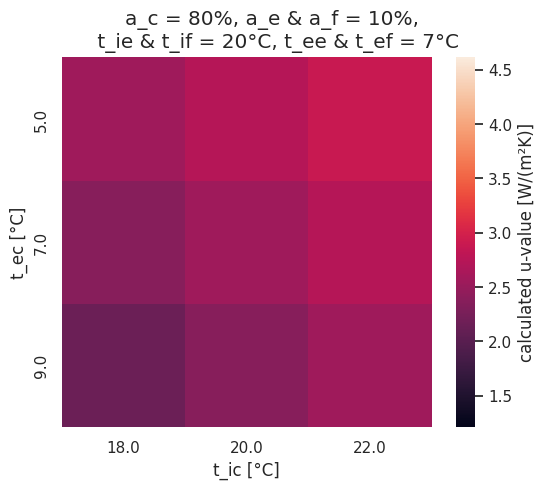

In [ ]:
# df_sa_u_win_full = df_sa_u_win

#df_sa_u_win_full = df_sa_u_win.loc[df_sa_u_win['t_ic'] == 20]
df_sa_u_win_full = df_sa_u_win.loc[df_sa_u_win['a_c'] == 80]

df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['a_e'] == 10]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['a_f'] == 10]

df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ie'] == 20]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_if'] == 20]

#df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ec'] == 7]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ee'] == 7]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ef'] == 7]




# df_sa_u_win_full = df_sa_u_win_full.drop(columns=['t_ic', 't_ie', 't_if', 't_ec', 't_ee', 't_ef' ])
df_sa_u_win_full = df_sa_u_win_full.drop(columns=['a_c', 'a_e', 'a_f', 't_ie', 't_if', 't_ee', 't_ef' ])

df_sa_u_win_full = df_sa_u_win_full.pivot(columns="t_ic", index="t_ec", values="Result")


plt.suptitle("a_c = 80%, a_e & a_f = 10%, \n t_ie & t_if = 20°C, t_ee & t_ef = 7°C")

ax0 = sns.heatmap(df_sa_u_win_full, cbar=1, vmin=u_min, vmax=u_max, square=1,
            cbar_kws={'label': 'calculated u-value [W/(m²K)]'} )

ax0.set(xlabel = 't_ic [°C]', ylabel = 't_ec [°C]')
ax0.invert_yaxis()

[Text(0.5, 19.049999999999997, 't_ic [°C]'),
 Text(73.45000000000006, 0.5, 't_ec [°C]')]

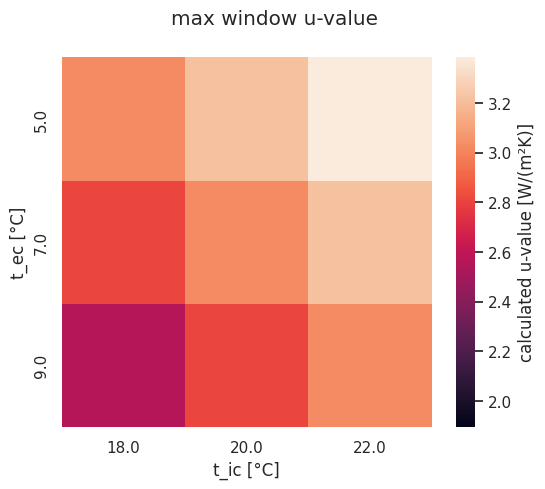

In [ ]:
# df_sa_u_win_full = df_sa_u_win

#df_sa_u_win_full = df_sa_u_win.loc[df_sa_u_win['t_ic'] == 20]
df_sa_u_win_full = df_sa_u_win.loc[df_sa_u_win['a_c'] == 80]

df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['a_e'] == 10]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['a_f'] == 10]

df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ie'] == 18]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_if'] == 18]

#df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ec'] == 7]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ee'] == 9]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ef'] == 9]




# df_sa_u_win_full = df_sa_u_win_full.drop(columns=['t_ic', 't_ie', 't_if', 't_ec', 't_ee', 't_ef' ])
df_sa_u_win_full = df_sa_u_win_full.drop(columns=['a_c', 'a_e', 'a_f', 't_ie', 't_if', 't_ee', 't_ef' ])

df_sa_u_win_full = df_sa_u_win_full.pivot(columns="t_ic", index="t_ec", values="Result")


plt.suptitle("max window u-value")

ax0 = sns.heatmap(df_sa_u_win_full, cbar=1, vmin=u_min, vmax=u_max, square=1,
                  cbar_kws={'label': 'calculated u-value [W/(m²K)]'} )

ax0.set(xlabel = 't_ic [°C]', ylabel = 't_ec [°C]')
ax0.invert_yaxis()

[Text(0.5, 19.049999999999997, 't_ic [°C]'),
 Text(73.45000000000006, 0.5, 't_ec [°C]')]

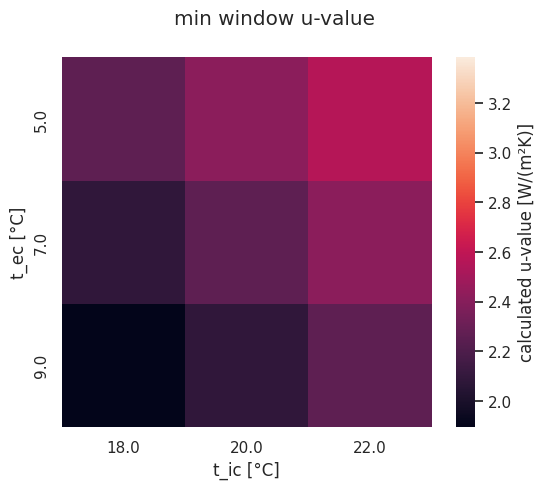

In [ ]:
# df_sa_u_win_full = df_sa_u_win

#df_sa_u_win_full = df_sa_u_win.loc[df_sa_u_win['t_ic'] == 20]
df_sa_u_win_full = df_sa_u_win.loc[df_sa_u_win['a_c'] == 80]

df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['a_e'] == 10]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['a_f'] == 10]

df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ie'] == 22]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_if'] == 22]

#df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ec'] == 7]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ee'] == 5]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ef'] == 5]




# df_sa_u_win_full = df_sa_u_win_full.drop(columns=['t_ic', 't_ie', 't_if', 't_ec', 't_ee', 't_ef' ])
df_sa_u_win_full = df_sa_u_win_full.drop(columns=['a_c', 'a_e', 'a_f', 't_ie', 't_if', 't_ee', 't_ef' ])

df_sa_u_win_full = df_sa_u_win_full.pivot(columns="t_ic", index="t_ec", values="Result")


plt.suptitle("min window u-value")

ax0 = sns.heatmap(df_sa_u_win_full, cbar=1, vmin=u_min, vmax=u_max, square=1,
                  cbar_kws={'label': 'calculated u-value [W/(m²K)]'} )

ax0.set(xlabel = 't_ic [°C]', ylabel = 't_ec [°C]')
ax0.invert_yaxis()

### Large set

In [9]:
#using the large df

df_sa_u_win_full = df_sa_u_win_large
u_max=df_sa_u_win_full['Result'].max()
u_min=df_sa_u_win_full['Result'].min()

In [10]:
df_temp = df_sa_u_win_full
df_temp[df_sa_u_win_full['Result']==df_sa_u_win_full['Result'].max()]

,t_ic,t_ec,t_ie,t_ee,t_if,t_ef,a_c,Result
63024,24.0,3.0,16.0,11.0,16.0,11.0,85.0,4.614


In [11]:
df_temp = df_sa_u_win_full
df_temp[df_sa_u_win_full['Result']==df_sa_u_win_full['Result'].min()]

,t_ic,t_ec,t_ie,t_ee,t_if,t_ef,a_c,Result
15104,16.0,11.0,24.0,3.0,24.0,3.0,85.0,1.210766


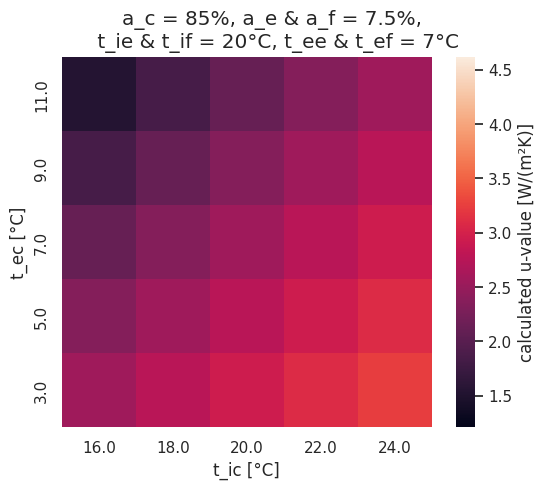

In [ ]:
df_sa_u_win_full = df_sa_u_win_large

#df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ic'] == 20]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['a_c'] == 85]

df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ie'] == 20]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_if'] == 20]

#df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ec'] == 7]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ee'] == 7]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ef'] == 7]




# df_sa_u_win_full = df_sa_u_win_full.drop(columns=['t_ic', 't_ie', 't_if', 't_ec', 't_ee', 't_ef' ])
df_sa_u_win_full = df_sa_u_win_full.drop(columns=['a_c', 't_ie', 't_if', 't_ee', 't_ef' ])

df_sa_u_win_full = df_sa_u_win_full.pivot(columns="t_ic", index="t_ec", values="Result")


plt.suptitle("a_c = 85%, a_e & a_f = 7.5%, \n t_ie & t_if = 20°C, t_ee & t_ef = 7°C")

ax0 = sns.heatmap(df_sa_u_win_full, cbar=1, vmin=u_min, vmax=u_max, square=1,
            cbar_kws={'label': 'calculated u-value [W/(m²K)]'} )

ax0.set(xlabel = 't_ic [°C]', ylabel = 't_ec [°C]')
ax0.invert_yaxis()

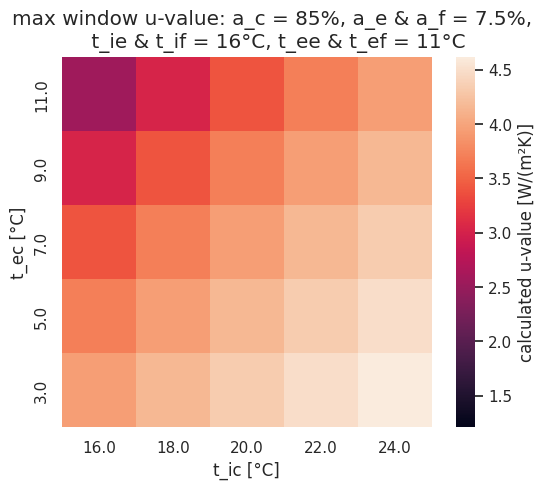

In [ ]:
df_sa_u_win_full = df_sa_u_win_large

#df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ic'] == 20]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['a_c'] == 85]

df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ie'] == 16]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_if'] == 16]

df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ee'] == 11]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ef'] == 11]




# df_sa_u_win_full = df_sa_u_win_full.drop(columns=['t_ic', 't_ie', 't_if', 't_ec', 't_ee', 't_ef' ])
df_sa_u_win_full = df_sa_u_win_full.drop(columns=['a_c', 't_ie', 't_if', 't_ee', 't_ef' ])

df_sa_u_win_full = df_sa_u_win_full.pivot(columns="t_ic", index="t_ec", values="Result")


plt.suptitle("max window u-value: a_c = 85%, a_e & a_f = 7.5%, \n t_ie & t_if = 16°C, t_ee & t_ef = 11°C")

ax0 = sns.heatmap(df_sa_u_win_full, cbar=1, vmin=u_min, vmax=u_max, square=1,
                  cbar_kws={'label': 'calculated u-value [W/(m²K)]'} )

ax0.set(xlabel = 't_ic [°C]', ylabel = 't_ec [°C]')
ax0.invert_yaxis()

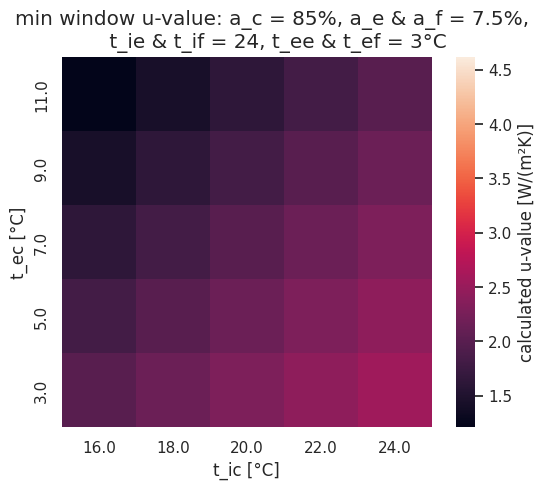

In [ ]:
df_sa_u_win_full = df_sa_u_win_large

#df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ic'] == 20]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['a_c'] == 85]

df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ie'] == 24]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_if'] == 24]

df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ee'] == 3]
df_sa_u_win_full = df_sa_u_win_full.loc[df_sa_u_win_full['t_ef'] == 3]




# df_sa_u_win_full = df_sa_u_win_full.drop(columns=['t_ic', 't_ie', 't_if', 't_ec', 't_ee', 't_ef' ])
df_sa_u_win_full = df_sa_u_win_full.drop(columns=['a_c', 't_ie', 't_if', 't_ee', 't_ef' ])

df_sa_u_win_full = df_sa_u_win_full.pivot(columns="t_ic", index="t_ec", values="Result")


plt.suptitle("min window u-value: a_c = 85%, a_e & a_f = 7.5%, \n t_ie & t_if = 24, t_ee & t_ef = 3°C")

ax0 = sns.heatmap(df_sa_u_win_full, cbar=1, vmin=u_min, vmax=u_max, square=1,
                  cbar_kws={'label': 'calculated u-value [W/(m²K)]'} )

ax0.set(xlabel = 't_ic [°C]', ylabel = 't_ec [°C]')
ax0.invert_yaxis()

## U-value calculation

### Formula definition and testing

In [ ]:
#define function
def uvalue_calc(ev,t_i,t_out,t_int,vel):
  ti = t_i + 273.15
  tout = t_out + 273.15
  tint = t_int + 273.15
  uvalue = (5.67*ev*(np.float_power((ti/100), 4)-np.float_power((tout/100), 4))+3.8054*vel*(ti-tout))/(tint-tout)
  return uvalue


In [ ]:
# Test
Kelvin = 273.15
ref_temp = .5
i_temp = 6.3
out_temp = ref_temp
int_temp = 22
v = 0
e_v = 0.9

T_int = int_temp + Kelvin
T_out = out_temp + Kelvin
T_i = i_temp + Kelvin

# Jurges equation Dallo paper 2013
h_we = 5.8 + 3.8054*v
h_we9 = 5.8*e_v + 3.8054*v
print(h_we)
Ud = h_we*((T_i-T_out)/(T_int-T_out))
print(Ud)
print(h_we9)
Ud9 = h_we9*((T_i-T_out)/(T_int-T_out))
print(Ud9)

# Uvalue calculation Albatici paper 2015
U = (5.67*e_v*(np.float_power((T_i/100), 4)-np.float_power((T_out/100), 4))+3.8054*v*(T_i-T_out))/(T_int-T_out)

print(U)

ucheck = uvalue_calc(e_v,i_temp,ref_temp,int_temp,v)

print(ucheck)


5.8
1.5646511627907007
5.22
1.4081860465116305
1.1647798142068113
1.1647798142068113


In [ ]:
# Test
Kelvin = 273.15
ref_temp = 2.9
i_temp = -1.15
out_temp = ref_temp
int_temp = 18
v = 0.5
e_v = 0.9

T_int = int_temp + Kelvin
T_out = out_temp + Kelvin
T_i = i_temp + Kelvin

# Jurges equation Dallo paper 2013
h_we = 5.8 + 3.8054*v
h_we9 = 5.8*e_v + 3.8054*v
print(h_we)
Ud = h_we*((T_i-T_out)/(T_int-T_out))
print(Ud)
print(h_we9)
Ud9 = h_we9*((T_i-T_out)/(T_int-T_out))
print(Ud9)

# Uvalue calculation Albatici paper 2015
U = (5.67*e_v*(np.float_power((T_i/100), 4)-np.float_power((T_out/100), 4))+3.8054*v*(T_i-T_out))/(T_int-T_out)

print(U)

ucheck = uvalue_calc(e_v,i_temp,ref_temp,int_temp,v)

print(ucheck)


7.7027
-2.0659559602648745
7.1227
-1.9103930463575916
-1.6368961178951815
-1.6368961178951815


### U-value formula sensitivity analysis

In [ ]:
sensitivity_dict = {
    'ev': [ 0.8, 0.85, 0.9, 0.95, 1 ],
    't_i': [0, 2.5, 5, 7.5, 10],
    't_out': [-2.5, 0, 2.5, 5, 7.5],
    't_int': [ 16, 18, 20, 22, 24],
    'vel': [0, 0.25, 0.5, 0.75, 1]
}

sa = SensitivityAnalyzer(sensitivity_dict, uvalue_calc)
sa.df
# plot = sa.plot()
# styled_df = sa.styled_dfs()

100%|██████████| 3125/3125 [00:04<00:00, 666.07it/s]


,ev,t_i,t_out,t_int,vel,Result
0,0.8,0.0,-2.5,16,0.0,0.492877
1,0.8,0.0,-2.5,16,0.25,0.621437
2,0.8,0.0,-2.5,16,0.5,0.749998
3,0.8,0.0,-2.5,16,0.75,0.878559
4,0.8,0.0,-2.5,16,1.0,1.00712
...,...,...,...,...,...,...
3120,1.0,10.0,7.5,24,0.0,0.769827
3121,1.0,10.0,7.5,24,0.25,0.91397
3122,1.0,10.0,7.5,24,0.5,1.058114
3123,1.0,10.0,7.5,24,0.75,1.202258


100%|██████████| 3125/3125 [00:04<00:00, 685.87it/s]


,0.000000,2.500000,5.000000,7.500000,10.000000
ev,,,,,
0.800000,-1.164602,-0.292604,0.595349,1.499546,2.420280
0.850000,-1.213285,-0.305135,0.619965,1.562326,2.522258
0.900000,-1.261968,-0.317667,0.644582,1.625107,2.624236
0.950000,-1.310651,-0.330199,0.669199,1.687887,2.726214
1.000000,-1.359334,-0.342730,0.693816,1.750668,2.828192


,-2.500000,0.000000,2.500000,5.000000,7.500000
ev,,,,,
0.800000,1.926533,1.468762,0.860063,0.018212,-1.215601
0.850000,2.006658,1.530214,0.896364,0.019350,-1.266457
0.900000,2.086783,1.591667,0.932665,0.020489,-1.317313
0.950000,2.166908,1.653119,0.968966,0.021627,-1.368169
1.000000,2.247032,1.714571,1.005267,0.022765,-1.419025


,16,18,20,22,24
ev,,,,,
0.800000,0.704175,0.654954,0.607689,0.564741,0.526410
0.850000,0.733702,0.682407,0.633155,0.588403,0.548462
0.900000,0.763229,0.709861,0.658621,0.612064,0.570515
0.950000,0.792756,0.737314,0.684087,0.635726,0.592567
1.000000,0.822284,0.764768,0.709553,0.659388,0.614620


,0.000000,0.250000,0.500000,0.750000,1.000000
ev,,,,,
0.800000,0.410114,0.510854,0.611594,0.712334,0.813074
0.850000,0.435746,0.536486,0.637226,0.737966,0.838706
0.900000,0.461378,0.562118,0.662858,0.763598,0.864338
0.950000,0.487010,0.587750,0.688490,0.789230,0.889970
1.000000,0.512642,0.613382,0.714122,0.814862,0.915602


,-2.500000,0.000000,2.500000,5.000000,7.500000
t_i,,,,,
0.000000,0.678159,0.000000,-0.898209,-2.137401,-3.952389
2.500000,1.369216,0.780856,0.000000,-1.078761,-2.659646
5.000000,2.073408,1.576554,0.915282,0.000000,-1.342333
7.500000,2.790974,2.387364,1.847946,1.099249,0.000000
10.000000,3.522155,3.213559,2.798308,2.219356,1.367803


,16,18,20,22,24
t_i,,,,,
0.000000,-1.726685,-1.417212,-1.201740,-1.043008,-0.921196
2.500000,-0.505157,-0.373691,-0.289065,-0.231045,-0.189377
5.000000,0.739588,0.689665,0.640957,0.596350,0.556351
7.500000,2.007973,1.773215,1.588643,1.439459,1.316243
10.000000,3.300426,2.877326,2.554310,2.298566,2.090553


,0.000000,0.250000,0.500000,0.750000,1.000000
t_i,,,,,
0.000000,-0.876296,-1.069132,-1.261968,-1.454804,-1.647640
2.500000,-0.225571,-0.271619,-0.317667,-0.363715,-0.409763
5.000000,0.443102,0.543842,0.644582,0.745322,0.846062
7.500000,1.130050,1.377578,1.625107,1.872635,2.120163
10.000000,1.835604,2.229920,2.624236,3.018553,3.412869


,16,18,20,22,24
t_out,,,,,
-2.500000,2.497420,2.253769,2.053434,1.885807,1.743482
0.000000,1.949221,1.732641,1.559376,1.417615,1.299480
2.500000,1.176832,1.024982,0.907842,0.814730,0.738941
5.000000,0.026920,0.022778,0.019741,0.017419,0.015585
7.500000,-1.834247,-1.484867,-1.247288,-1.075248,-0.944915


,0.000000,0.250000,0.500000,0.750000,1.000000
t_out,,,,,
-2.500000,1.442249,1.764516,2.086783,2.409049,2.731316
0.000000,1.106142,1.348904,1.591667,1.834429,2.077191
2.500000,0.653419,0.793042,0.932665,1.072289,1.211912
5.000000,0.020489,0.020489,0.020489,0.020489,0.020489
7.500000,-0.915409,-1.116361,-1.317313,-1.518265,-1.719217


,0.000000,0.250000,0.500000,0.750000,1.000000
t_int,,,,,
16,0.531490,0.647360,0.763229,0.879098,0.994968
18,0.494161,0.602011,0.709861,0.817711,0.925561
20,0.458385,0.558503,0.658621,0.758739,0.858858
22,0.425909,0.518987,0.612064,0.705142,0.798219
24,0.396944,0.483729,0.570515,0.657300,0.744085


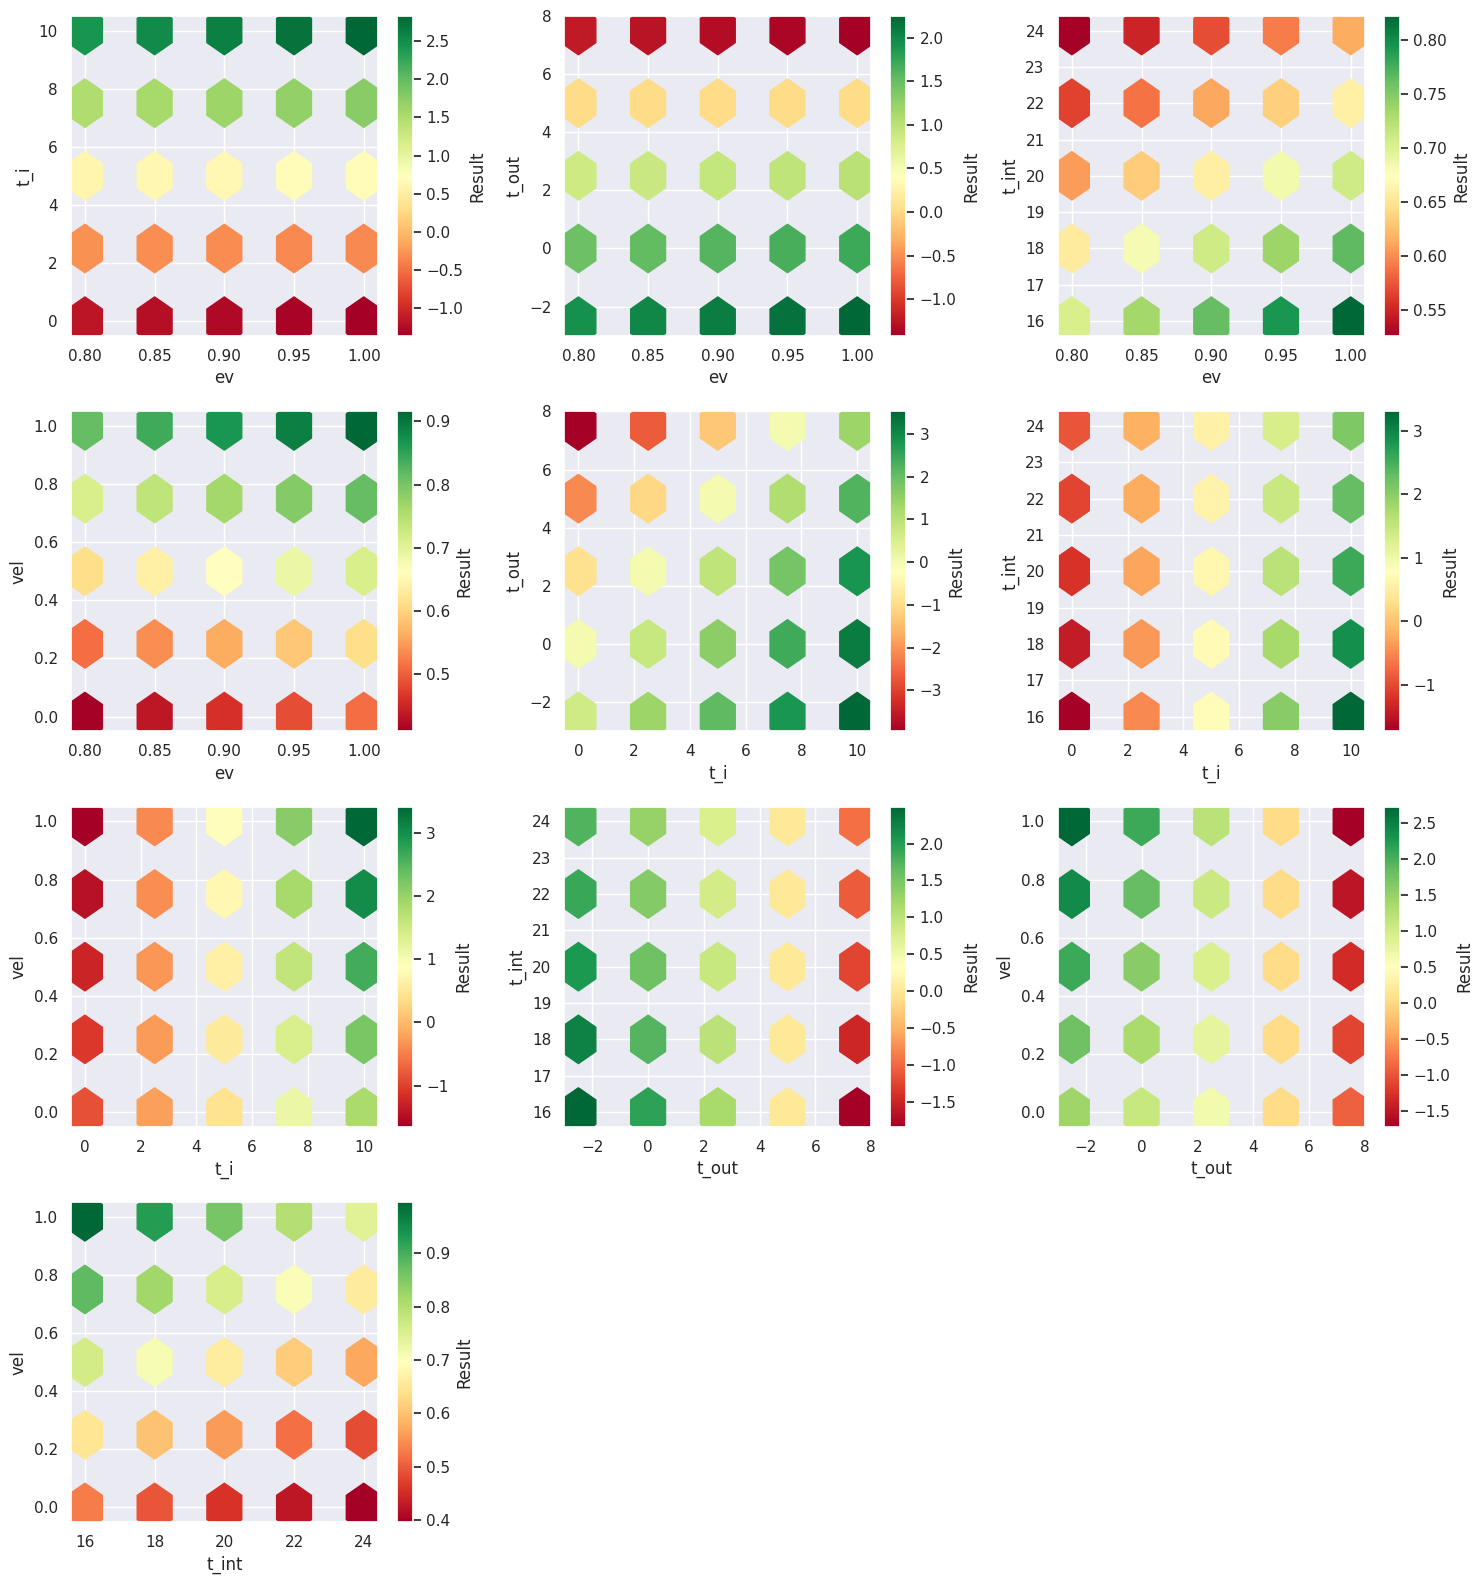

In [ ]:
# sa = SensitivityAnalyzer(sensitivity_dict, uvalue_calc, grid_size=3)
sa = SensitivityAnalyzer(sensitivity_dict, uvalue_calc)

plot = sa.plot()

styled_dict = sa.styled_dfs()

In [ ]:
sa.df.to_csv('sa_uvalue.csv', index=False)

100%|██████████| 3125/3125 [00:03<00:00, 932.55it/s]


,2,3,4,5,6
ev,,,,,
0.800000,0.539163,0.827229,1.117392,1.409667,1.704070
0.850000,0.561456,0.861519,1.163811,1.468346,1.775142
0.900000,0.583749,0.895810,1.210230,1.527025,1.846214
0.950000,0.606042,0.930100,1.256648,1.585704,1.917287
1.000000,0.628334,0.964390,1.303067,1.644383,1.988359


,-2,-1,0,1,2
ev,,,,,
0.800000,1.546944,1.356258,1.144325,0.907726,0.642268
0.850000,1.611060,1.412581,1.191941,0.945577,0.669114
0.900000,1.675177,1.468904,1.239558,0.983428,0.695961
0.950000,1.739293,1.525227,1.287175,1.021279,0.722807
1.000000,1.803410,1.581549,1.334791,1.059130,0.749653


,18,19,20,21,22
ev,,,,,
0.800000,1.235765,1.171730,1.114033,1.061775,1.014217
0.850000,1.287151,1.220453,1.160357,1.105924,1.056389
0.900000,1.338537,1.269175,1.206680,1.150074,1.098561
0.950000,1.389923,1.317898,1.253003,1.194224,1.140733
1.000000,1.441309,1.366621,1.299326,1.238374,1.182904


,0.000000,0.250000,0.500000,0.750000,1.000000
ev,,,,,
0.800000,0.744811,0.932157,1.119504,1.306851,1.494198
0.850000,0.791361,0.978708,1.166055,1.353402,1.540748
0.900000,0.837912,1.025259,1.212605,1.399952,1.587299
0.950000,0.884463,1.071809,1.259156,1.446503,1.633850
1.000000,0.931013,1.118360,1.305707,1.493054,1.680400


,-2,-1,0,1,2
t_i,,,,,
2,1.106930,0.873355,0.613938,0.324520,0.000000
3,1.388914,1.168888,0.924393,0.651493,0.345360
4,1.673030,1.466654,1.237194,0.980939,0.693331
5,1.959292,1.766670,1.552360,1.312873,1.043931
6,2.247718,2.068953,1.869906,1.647315,1.397180


,18,19,20,21,22
t_i,,,,,
2,0.642577,0.610267,0.581059,0.554525,0.530314
3,0.987937,0.937241,0.891514,0.850058,0.812298
4,1.335908,1.266686,1.204316,1.147824,1.096414
5,1.686508,1.598621,1.519481,1.447840,1.382676
6,2.039757,1.933063,1.837027,1.750123,1.671102


,0.000000,0.250000,0.500000,0.750000,1.000000
t_i,,,,,
2,0.401274,0.492511,0.583749,0.674986,0.766223
3,0.617226,0.756518,0.895810,1.035102,1.174394
4,0.835536,1.022883,1.210230,1.397576,1.584923
5,1.056222,1.291624,1.527025,1.762427,1.997828
6,1.279302,1.562758,1.846214,2.129670,2.413127


,18,19,20,21,22
t_out,,,,,
-2,1.835058,1.747674,1.668234,1.595702,1.529215
-1,1.616139,1.535332,1.462221,1.395756,1.335071
0,1.370376,1.298251,1.233338,1.174608,1.121217
1,1.093012,1.032289,0.977958,0.929060,0.884819
2,0.778102,0.732331,0.691646,0.655243,0.622481


,0.000000,0.250000,0.500000,0.750000,1.000000
t_out,,,,,
-2,1.154099,1.414638,1.675177,1.935716,2.196254
-1,1.013810,1.241357,1.468904,1.696451,1.923998
0,0.857099,1.048329,1.239558,1.430788,1.622017
1,0.681321,0.832375,0.983428,1.134481,1.285535
2,0.483231,0.589596,0.695961,0.802326,0.908691


,0.000000,0.250000,0.500000,0.750000,1.000000
t_int,,,,,
18,0.924947,1.131742,1.338537,1.545332,1.752128
19,0.877008,1.073092,1.269175,1.465259,1.661343
20,0.833816,1.020248,1.206680,1.393112,1.579543
21,0.794695,0.972384,1.150074,1.327764,1.505453
22,0.759094,0.928827,1.098561,1.268294,1.438028


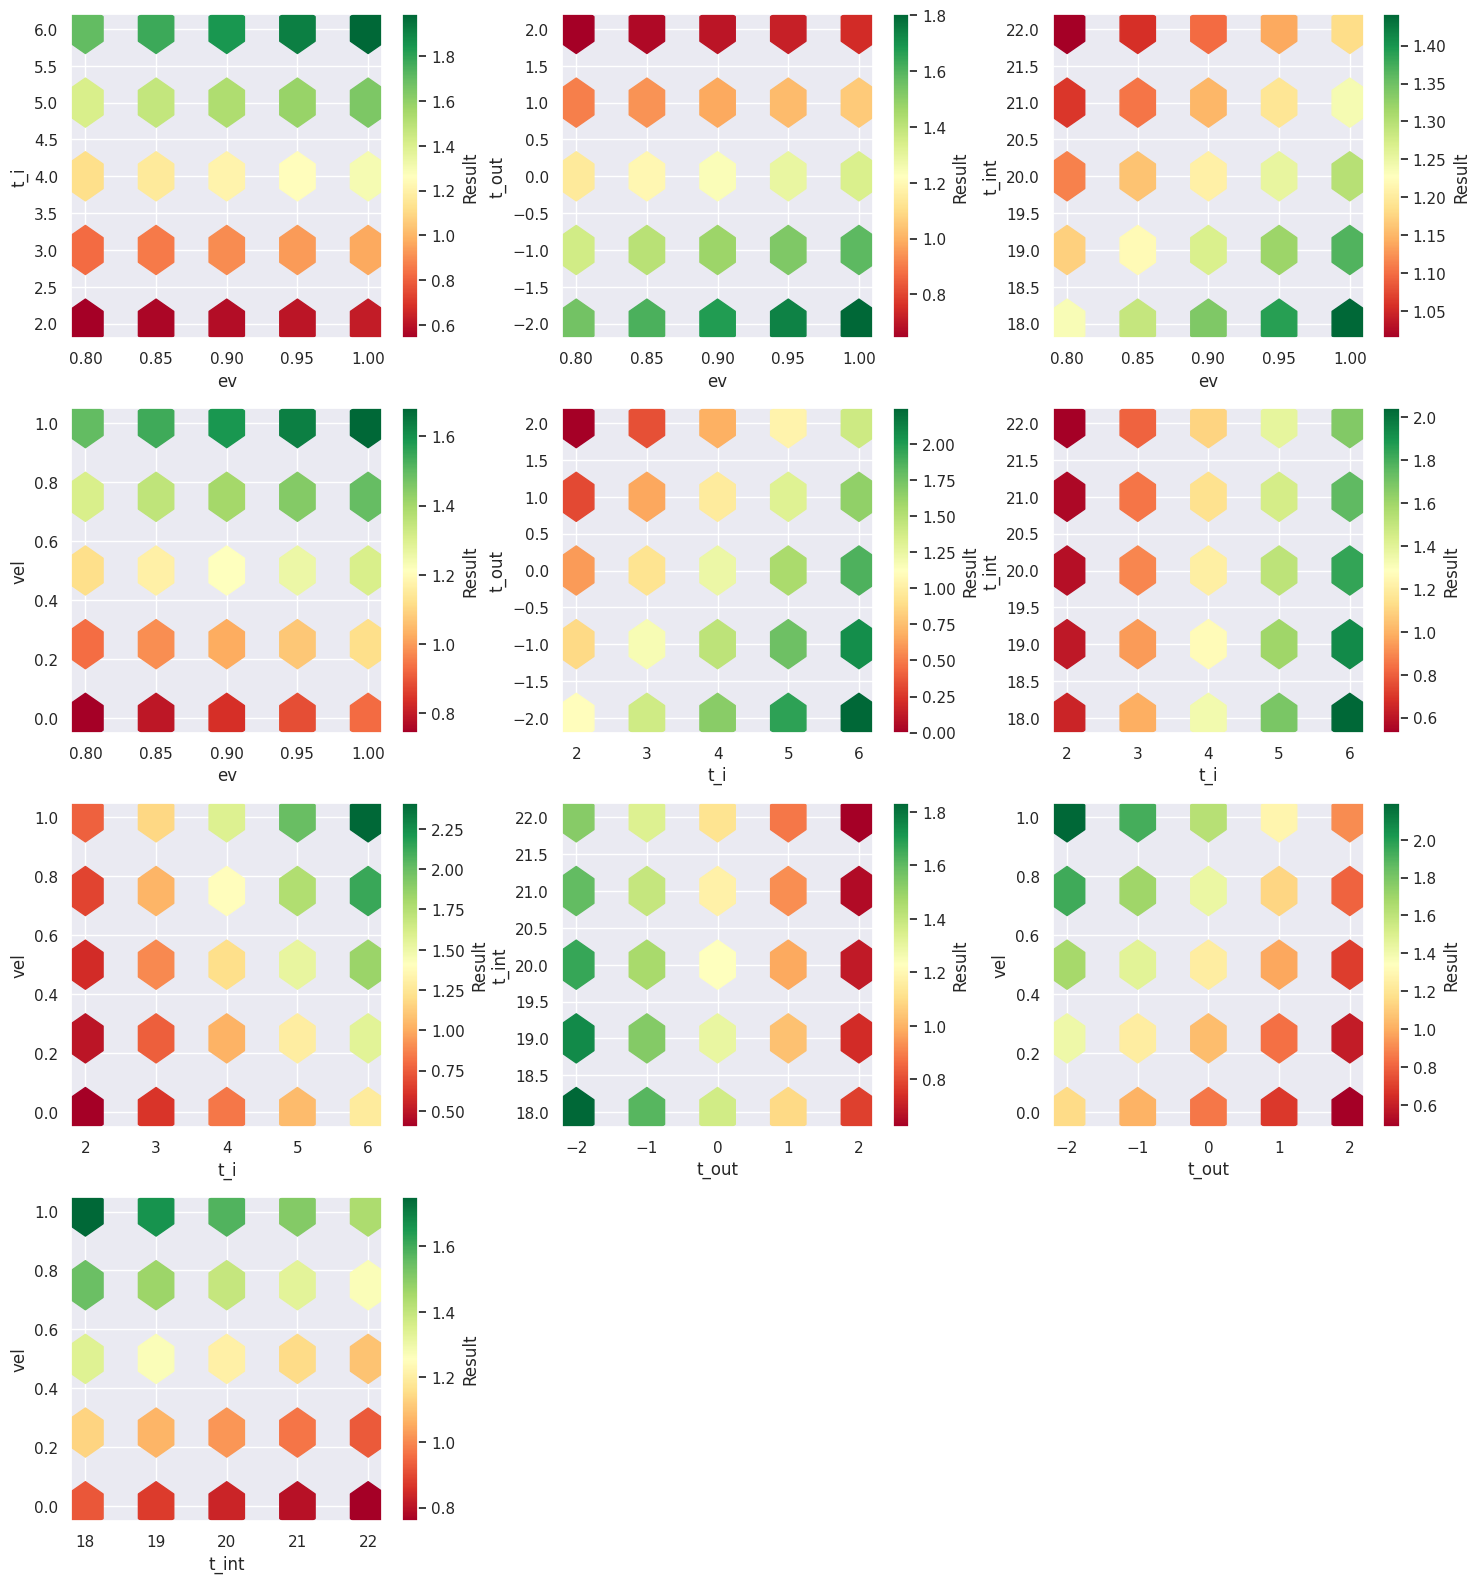

In [ ]:
sensitivity_dict = {
    'ev': [ 0.8, 0.85, 0.9, 0.95, 1 ],
    't_i': [ 2, 3, 4, 5, 6 ],
    't_out': [ -2, -1, 0, 1, 2 ],
    't_int': [ 18, 19, 20, 21, 22 ],
    'vel': [ 0, 0.25, 0.5, 0.75, 1]
}

sa = SensitivityAnalyzer(sensitivity_dict, uvalue_calc)

plot = sa.plot()

styled_dict = sa.styled_dfs()

sa.df.to_csv('sa_uvalue_new.csv', index=False)

In [ ]:
df_temp = sa.df
df_temp[sa.df['Result']==sa.df['Result'].max()]

,ev,t_i,t_out,t_int,vel,Result
3004,1.0,6,-2,18,1.0,3.412341


In [ ]:
df_temp = sa.df
df_temp[sa.df['Result']==sa.df['Result'].min()]

,ev,t_i,t_out,t_int,vel,Result
100,0.8,2,2,18,0.0,0.0
101,0.8,2,2,18,0.25,0.0
102,0.8,2,2,18,0.5,0.0
103,0.8,2,2,18,0.75,0.0
104,0.8,2,2,18,1.0,0.0
...,...,...,...,...,...,...
2620,1.0,2,2,22,0.0,0.0
2621,1.0,2,2,22,0.25,0.0
2622,1.0,2,2,22,0.5,0.0
2623,1.0,2,2,22,0.75,0.0


## Temperature calculation from raw data FLIR

### Formula definitions

In [ ]:
# Calibration / camera-specific parameters
sensorR = 19435.332
sensorB = 1430
sensorF = 1.05
sensorO = -3626
gGain = 0.016836865

# Atmospheric transmission parameters
atmAlpha1 = 0
atmAlpha2 = 0
atmBeta1 = 0.00318
atmBeta2 = 0.00318
atmX = 0.732

# User-set parameters
appReflTemp_C = 30
airTemp_C = 1
airRelHumidity_perc = 50
objDistance_m = 10

appReflTemp_K = appReflTemp_C+273.15;
airTemp_K = airTemp_C+273.15;
airWaterContent = airRelHumidity_perc /100 * np.exp(1.5587 + 0.06939 * airTemp_C - 0.00027816 * pow(airTemp_C,2) + 0.00000068455 *pow(airTemp_C,3));
atmTau = atmX * np.exp(-pow(objDistance_m,0.5) * (atmAlpha1 + atmBeta1 * pow(airWaterContent,0.5))) + (1-atmX) * np.exp(-pow(objDistance_m,0.5) * (atmAlpha2 + atmBeta2 * pow(airWaterContent,0.5)));
atmRawSignal_DN = sensorR/(gGain*(np.exp(sensorB/(airTemp_K))-sensorF))-sensorO;
reflRawSignal_DN = sensorR/(gGain*(np.exp(sensorB/(appReflTemp_K))-sensorF))-sensorO;

In [ ]:
def IRcounts2temp(objEmissivity, rawSignal_DN):
    objRawSignal_DN=(rawSignal_DN-atmRawSignal_DN*(1-atmTau)-reflRawSignal_DN*(1-objEmissivity)*atmTau)/objEmissivity/atmTau;
    objTemp_C=sensorB/np.log(sensorR/(gGain*(objRawSignal_DN+sensorO))+sensorF)-273.15;
    return objTemp_C

In [ ]:
def FULLIRcounts2temp(appReflTemp_C,
                      airTemp_C,
                      airRelHumidity_perc,
                      objDistance_m,
                      objEmissivity,
                      rawSignal_DN):
    appReflTemp_K = appReflTemp_C+273.15;
    airTemp_K = airTemp_C+273.15;
    airWaterContent = airRelHumidity_perc /100 * np.exp(1.5587 + 0.06939 * airTemp_C - 0.00027816 * pow(airTemp_C,2) + 0.00000068455 *pow(airTemp_C,3));
    atmTau = atmX * np.exp(-pow(objDistance_m,0.5) * (atmAlpha1 + atmBeta1 * pow(airWaterContent,0.5))) + (1-atmX) * np.exp(-pow(objDistance_m,0.5) * (atmAlpha2 + atmBeta2 * pow(airWaterContent,0.5)));
    atmRawSignal_DN = sensorR/(gGain*(np.exp(sensorB/(airTemp_K))-sensorF))-sensorO;
    reflRawSignal_DN = sensorR/(gGain*(np.exp(sensorB/(appReflTemp_K))-sensorF))-sensorO;

    objRawSignal_DN=(rawSignal_DN-atmRawSignal_DN*(1-atmTau)-reflRawSignal_DN*(1-objEmissivity)*atmTau)/objEmissivity/atmTau;
    objTemp_C=sensorB/np.log(sensorR/(gGain*(objRawSignal_DN+sensorO))+sensorF)-273.15;

    return objTemp_C

### Importing RJPG

In [ ]:
# https://colab.research.google.com/drive/1OuaAnxqct3E4OAbddcA74vcNF4uwQyx4#scrollTo=DbMe6SJsOkpn
!apt-get install exiftool

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libimage-exiftool-perl' instead of 'exiftool'
The following additional packages will be installed:
  libarchive-zip-perl libmime-charset-perl libsombok3 libunicode-linebreak-perl
Suggested packages:
  libposix-strptime-perl libencode-hanextra-perl libpod2-base-perl
The following NEW packages will be installed:
  libarchive-zip-perl libimage-exiftool-perl libmime-charset-perl libsombok3
  libunicode-linebreak-perl
0 upgraded, 5 newly installed, 0 to remove and 29 not upgraded.
Need to get 3,964 kB of archives.
After this operation, 23.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-zip-perl all 1.68-1 [90.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libimage-exiftool-perl all 12.40+dfsg-1 [3,717 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmime-charset-perl all 1.012.2-1

In [ ]:
# Option to use Exifread instead of ExifTool
# https://pypi.org/project/ExifRead/

# pip install exifread
# import exifread
# # Open image file for reading (must be in binary mode)
# f = open('Snap-0105.jpg', 'r')
# print(f)

In [ ]:
def getrawim_data(impath):
# Obtaining metadata from the rjpg image and separating the raw thermal image
    tags = !exiftool $impath
    !exiftool $impath -RawThermalImage -b -w ".png"
    rawim = impath.split('.jpg')
    rawim = rawim[0] + '.png'
    im = Image.open(rawim)

    # Creating a dictionary from all of the metadata tags
    dic = {}
    lentags = len(tags)
    for i in range(lentags):
        split = tags[i].split(':')
        indexkey = split[0].strip()
        value = split[1].strip()
        dic[indexkey] = value

    return im, dic

In [ ]:
def getCalParameters(dic):
    # Calibration / camera-specific parameters
    sensorR = float(dic['Planck R1'])
    sensorB = float(dic['Planck B'])
    sensorF = float(dic['Planck F'])
    sensorO = float(dic['Planck O'])
    gGain = float(dic['Planck R2'])
    return sensorR, sensorB, sensorF, sensorO, gGain

def getAtmParameters(dic):
    # Atmospheric transmission parameters
    atmAlpha1 = float(dic['Atmospheric Trans Alpha 1'])
    atmAlpha2 = float(dic['Atmospheric Trans Alpha 2'])
    atmBeta1 = float(dic['Atmospheric Trans Beta 1'])
    atmBeta2 = float(dic['Atmospheric Trans Beta 2'])
    atmX = float(dic['Atmospheric Trans X'])
    return atmAlpha1, atmAlpha2, atmBeta1, atmBeta2, atmX

In [ ]:
# Obtaining data from image
objEmissivity = float(dic['Emissivity'])

# Calibration / camera-specific parameters
sensorR = float(dic['Planck R1'])
sensorB = float(dic['Planck B'])
sensorF = float(dic['Planck F'])
sensorO = float(dic['Planck O'])
gGain = float(dic['Planck R2'])

# Atmospheric transmission parameters
atmAlpha1 = float(dic['Atmospheric Trans Alpha 1'])
atmAlpha2 = float(dic['Atmospheric Trans Alpha 2'])
atmBeta1 = float(dic['Atmospheric Trans Beta 1'])
atmBeta2 = float(dic['Atmospheric Trans Beta 2'])
atmX = float(dic['Atmospheric Trans X'])

# User-set parameters
appReflT = dic['Reflected Apparent Temperature'].split(' ')
appReflTemp_C = float(appReflT[0])
airT = dic['Atmospheric Temperature'].split(' ')
airTemp_C = float(airT[0])
airRelHum = dic['Relative Humidity'].split(' ')
airRelHumidity_perc = float(airRelHum[0])
objD = dic['Object Distance'].split(' ')
objDistance_m = float(objD[0])

if appReflT[1] == 'C':
  print('Reflected Apparent Temperature is %.2f C' % appReflTemp_C)
else:
  print('Reflected Apparent Temperature is in F; temperature needs to transformed into C')
  appReflTemp_C = (appReflTemp_C - 32) * 5.0/9.0
  print('New temperature %.2f C' % appReflTemp_C)

if airT[1] == 'C':
  print('Atmospheric Temperature is %.2f C' % airTemp_C)
else:
  print('Atmospheric Temperature is in F; temperature needs to transformed into C')
  airTemp_C = (airTemp_C - 32) * 5.0/9.0
  print('New temperature %.2f C' % airTemp_C)

if objD[1] == 'm':
  print('Object distance is %.2f m' % objDistance_m)
else:
  print('Object distance is in feet; distance needs to transformed into m')
  objDistance_m = (objDistance_m) /3.281
  print('New distance is %.2f m' % objDistance_m)

NameError: name 'dic' is not defined

In [ ]:
def im2newtemp(impath,
               objEmissivity = None,
               appReflTemp_C = None,
               airTemp_C = None,
               airRelHumidity_perc = None,
               objDistance_m = None):
    # Obtaining metadata from the rjpg image and separating the raw thermal image
    tags = !exiftool $impath
    !exiftool $impath -RawThermalImage -b -w ".png"
    rawim = impath.split('.jpg')
    rawim = rawim[0] + '.png'
    rawSignal_DN = Image.open(rawim)

    # Creating a dictionary from all of the metadata tags
    dic = {}
    lentags = len(tags)
    for i in range(lentags):
        split = tags[i].split(':')
        indexkey = split[0].strip()
        value = split[1].strip()
        dic[indexkey] = value

    print('The User-set Parameters are the following:')
    # Obtaining data from image
    if objEmissivity == None:
        objEmissivity = float(dic['Emissivity'])
    print('Object Emissivity is %.2f' % objEmissivity)

    # Calibration / camera-specific parameters
    sensorR = float(dic['Planck R1'])
    sensorB = float(dic['Planck B'])
    sensorF = float(dic['Planck F'])
    sensorO = float(dic['Planck O'])
    gGain = float(dic['Planck R2'])

    # Atmospheric transmission parameters
    atmAlpha1 = float(dic['Atmospheric Trans Alpha 1'])
    atmAlpha2 = float(dic['Atmospheric Trans Alpha 2'])
    atmBeta1 = float(dic['Atmospheric Trans Beta 1'])
    atmBeta2 = float(dic['Atmospheric Trans Beta 2'])
    atmX = float(dic['Atmospheric Trans X'])

    # User-set parameters
    if appReflTemp_C == None:
        appReflT = dic['Reflected Apparent Temperature'].split(' ')
        appReflTemp_C = float(appReflT[0])

        if appReflT[1] == 'C':
          print('Reflected Apparent Temperature is %.2f C' % appReflTemp_C)
        else:
          print('Reflected Apparent Temperature is in F; temperature needs to transformed into C')
          appReflTemp_C = (appReflTemp_C - 32) * 5.0/9.0
          print('New temperature %.2f C' % appReflTemp_C)


    if airTemp_C == None:
        airT = dic['Atmospheric Temperature'].split(' ')
        airTemp_C = float(airT[0])

        if airT[1] == 'C':
          print('Atmospheric Temperature is %.2f C' % airTemp_C)
        else:
          print('Atmospheric Temperature is in F; temperature needs to transformed into C')
          airTemp_C = (airTemp_C - 32) * 5.0/9.0
          print('New temperature %.2f C' % airTemp_C)


    if airRelHumidity_perc == None:
        airRelHum = dic['Relative Humidity'].split(' ')
        airRelHumidity_perc = float(airRelHum[0])
        print('Relative Humidity is %.2f %%' % airRelHumidity_perc)


    if objDistance_m == None:
        objD = dic['Object Distance'].split(' ')
        objDistance_m = float(objD[0])

        if objD[1] == 'm':
          print('Object distance is %.2f m' % objDistance_m)
        else:
          print('Object distance is in feet; distance needs to transformed into m')
          objDistance_m = (objDistance_m) /3.281
          print('New distance is %.2f m' % objDistance_m)


    appReflTemp_K = appReflTemp_C+273.15;
    airTemp_K = airTemp_C+273.15;
    airWaterContent = airRelHumidity_perc /100 * np.exp(1.5587 + 0.06939 * airTemp_C - 0.00027816 * pow(airTemp_C,2) + 0.00000068455 *pow(airTemp_C,3));
    atmTau = atmX * np.exp(-pow(objDistance_m,0.5) * (atmAlpha1 + atmBeta1 * pow(airWaterContent,0.5))) + (1-atmX) * np.exp(-pow(objDistance_m,0.5) * (atmAlpha2 + atmBeta2 * pow(airWaterContent,0.5)));
    atmRawSignal_DN = sensorR/(gGain*(np.exp(sensorB/(airTemp_K))-sensorF))-sensorO;
    reflRawSignal_DN = sensorR/(gGain*(np.exp(sensorB/(appReflTemp_K))-sensorF))-sensorO;

    objRawSignal_DN=(rawSignal_DN-atmRawSignal_DN*(1-atmTau)-reflRawSignal_DN*(1-objEmissivity)*atmTau)/objEmissivity/atmTau;
    objTemp_C=sensorB/np.log(sensorR/(gGain*(objRawSignal_DN+sensorO))+sensorF)-273.15;

    return objTemp_C

### NOT WORKING

In [ ]:
def FULLIRcounts2temp_wobjs(appReflTemp_C,
                      airTemp_C,
                      airRelHumidity_perc,
                      objDistance_m,
                      objEmissivity,
                      rawSignal_DN, this_brofg):
    appReflTemp_K = appReflTemp_C+273.15;
    airTemp_K = airTemp_C+273.15;
    airWaterContent = airRelHumidity_perc /100 * np.exp(1.5587 + 0.06939 * airTemp_C - 0.00027816 * pow(airTemp_C,2) + 0.00000068455 *pow(airTemp_C,3));
    atmTau = atmX * np.exp(-pow(objDistance_m,0.5) * (atmAlpha1 + atmBeta1 * pow(airWaterContent,0.5))) + (1-atmX) * np.exp(-pow(objDistance_m,0.5) * (atmAlpha2 + atmBeta2 * pow(airWaterContent,0.5)));
    atmRawSignal_DN = this_brofg.R/(this_brofg.G*(np.exp(this_brofg.B/(airTemp_K))-this_brofg.F))-this_brofg.O;
    reflRawSignal_DN = this_brofg.R/(this_brofg.G*(np.exp(this_brofg.B/(appReflTemp_K))-this_brofg.F))-this_brofg.O;

    objRawSignal_DN=(rawSignal_DN-atmRawSignal_DN*(1-atmTau)-reflRawSignal_DN*(1-objEmissivity)*atmTau)/objEmissivity/atmTau;
    objTemp_C=this_brofg.B/np.log(this_brofg.R/(this_brofg.G*(objRawSignal_DN+this_brofg.O))+this_brofg.F)-273.15;

    return objTemp_C

In [ ]:
#testing to simplify function, but would need to pass all parameters to the function.
#When tried it resulted in it using the parameters which were called in the actual terminal
class brofg:
  def __init__(self,calc_parameters):
    self.R, self.B, self.F, self.O, self.G = calc_parameters

def TESTnew_im2temp(impath,
               objEmissivity = None,
               appReflTemp_C = None,
               airTemp_C = None,
               airRelHumidity_perc = None,
               objDistance_m = None):

    rawimg, dic = getrawim_data(impath)

    myBrofg = brofg(getCalParameters(dic))
    #sensorR, sensorB, sensorF, sensorO, gGain = getCalParameters(dic)
    print(myBrofg.R)

    atmAlpha1, atmAlpha2, atmBeta1, atmBeta2, atmX = getAtmParameters(dic)
    print(atmAlpha1, atmAlpha2, atmBeta1, atmBeta2, atmX)

    print('The User-set Parameters are the following:')
    # Obtaining data from image
    if objEmissivity == None:
        objEmissivity = float(dic['Emissivity'])
    print('Object Emissivity is %.2f' % objEmissivity)

        # User-set parameters
    if appReflTemp_C == None:
        appReflT = dic['Reflected Apparent Temperature'].split(' ')
        appReflTemp_C = float(appReflT[0])

        if appReflT[1] == 'C':
          print('Reflected Apparent Temperature is %.2f C' % appReflTemp_C)
        else:
          print('Reflected Apparent Temperature is in F; temperature needs to transformed into C')
          appReflTemp_C = (appReflTemp_C - 32) * 5.0/9.0
          print('New temperature %.2f C' % appReflTemp_C)


    if airTemp_C == None:
        airT = dic['Atmospheric Temperature'].split(' ')
        airTemp_C = float(airT[0])

        if airT[1] == 'C':
          print('Atmospheric Temperature is %.2f C' % airTemp_C)
        else:
          print('Atmospheric Temperature is in F; temperature needs to transformed into C')
          airTemp_C = (airTemp_C - 32) * 5.0/9.0
          print('New temperature %.2f C' % airTemp_C)


    if airRelHumidity_perc == None:
        airRelHum = dic['Relative Humidity'].split(' ')
        airRelHumidity_perc = float(airRelHum[0])
        print('Relative Humidity is %.2f %%' % airRelHumidity_perc)


    if objDistance_m == None:
        objD = dic['Object Distance'].split(' ')
        objDistance_m = float(objD[0])

        if objD[1] == 'm':
          print('Object distance is %.2f m' % objDistance_m)
        else:
          print('Object distance is in feet; distance needs to transformed into m')
          objDistance_m = (objDistance_m) /3.281
          print('New distance is %.2f m' % objDistance_m)


    # appReflTemp_K = appReflTemp_C+273.15;
    # airTemp_K = airTemp_C+273.15;
    # airWaterContent = airRelHumidity_perc /100 * np.exp(1.5587 + 0.06939 * airTemp_C - 0.00027816 * pow(airTemp_C,2) + 0.00000068455 *pow(airTemp_C,3));
    # atmTau = atmX * np.exp(-pow(objDistance_m,0.5) * (atmAlpha1 + atmBeta1 * pow(airWaterContent,0.5))) + (1-atmX) * np.exp(-pow(objDistance_m,0.5) * (atmAlpha2 + atmBeta2 * pow(airWaterContent,0.5)));
    # atmRawSignal_DN = sensorR/(gGain*(np.exp(sensorB/(airTemp_K))-sensorF))-sensorO;
    # reflRawSignal_DN = sensorR/(gGain*(np.exp(sensorB/(appReflTemp_K))-sensorF))-sensorO;

    # objRawSignal_DN=(rawimg-atmRawSignal_DN*(1-atmTau)-reflRawSignal_DN*(1-objEmissivity)*atmTau)/objEmissivity/atmTau;
    # objTemp_C=sensorB/np.log(sensorR/(gGain*(objRawSignal_DN+sensorO))+sensorF)-273.15;

    objTemp_C = FULLIRcounts2temp_wobjs(appReflTemp_C,
                      airTemp_C,
                      airRelHumidity_perc,
                      objDistance_m,
                      objEmissivity,
                      rawimg,
                                  myBrofg)

    return objTemp_C

In [ ]:
im79, dic = getrawim_data('IR_0079.jpg')
sensorR, sensorB, sensorF, sensorO, gGain = getCalParameters(dic)
atmAlpha1, atmAlpha2, atmBeta1, atmBeta2, atmX = getAtmParameters(dic)

IRfulltempTEST = TESTnew_im2temp('IR_0079.jpg')
sns.heatmap(IRfulltempTEST, annot=False, fmt=".2f", xticklabels=False, yticklabels=False)
print(IRfulltempTEST.min())
print(IRfulltempTEST.max())

In [ ]:
im79, dic = getrawim_data('Snap-0105.jpg')
sensorR, sensorB, sensorF, sensorO, gGain = getCalParameters(dic)
atmAlpha1, atmAlpha2, atmBeta1, atmBeta2, atmX = getAtmParameters(dic)

IRfulltempTEST = TESTnew_im2temp('IR_0079.jpg')
sns.heatmap(IRfulltempTEST, annot=False, fmt=".2f", xticklabels=False, yticklabels=False)
print(IRfulltempTEST.min())
print(IRfulltempTEST.max())

### Testing

In [ ]:
im = Image.open('Snap-0105.png', 'r')
width, height = raw_im.size
pixel_values = list(raw_im.getdata())
pixel_values = np.array(pixel_values).reshape((height, width))

NameError: name 'raw_im' is not defined

In [ ]:
sns.heatmap(pixel_values, annot=False, fmt=".2f", xticklabels=False, yticklabels=False)

NameError: name 'pixel_values' is not defined

In [ ]:
# Find the maximum and minimum values in the data array
data_max = pixel_values.max()
data_min = pixel_values.min()

# Set the colormap range from min to max values
#cmap = sns.diverging_palette(240, 10, as_cmap=True)
cmap = sns.diverging_palette(240, 10, as_cmap=True)
# Plotting the array with Seaborn heatmap
sns.heatmap(pixel_values, annot=False, fmt=".2f", cmap=cmap, vmin=data_min, vmax=data_max, xticklabels=False, yticklabels=False, cbar=True )

In [ ]:
IRtemp_array = IRcounts2temp(.9, pixel_values)

In [ ]:
sns.heatmap(IRtemp_array, annot=False, fmt=".2f", xticklabels=False, yticklabels=False)

In [ ]:
print(IRtemp_array.min())
print(IRtemp_array.max())

In [ ]:
myimpath = 'Snap-0105.jpg'
imim, imdic = getrawim_data(myimpath)

In [ ]:
for i in imdic:
  print(imdic[i])

    1 output files created
The User-set Parameters are the following:
Object Emissivity is 0.90
Reflected Apparent Temperature is 30.00 C
Atmospheric Temperature is 1.00 C
Relative Humidity is 50.00 %
Object distance is 10.00 m
-8.126679851366703
13.978856755715753


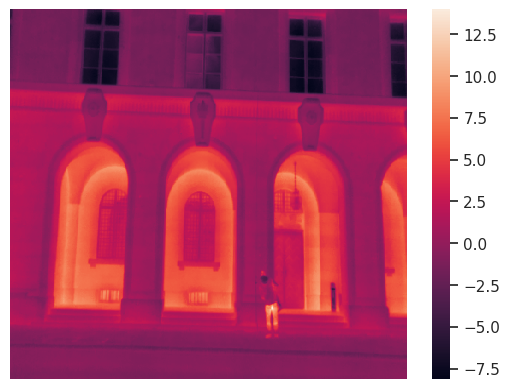

In [ ]:
IRfulltempdifval = im2newtemp('Snap-0105.jpg')
sns.heatmap(IRfulltempdifval, annot=False, fmt=".2f", xticklabels=False, yticklabels=False)
print(IRfulltempdifval.min())
print(IRfulltempdifval.max())

In [ ]:
IRfulltemp = FULLIRcounts2temp(3, 1, 50, 5, 0.9, pixel_values)
sns.heatmap(IRfulltemp, annot=False, fmt=".2f", xticklabels=False, yticklabels=False)
print(IRfulltemp.min())
print(IRfulltemp.max())

NameError: name 'pixel_values' is not defined

### FLIR One

    1 output files created
The User-set Parameters are the following:
Object Emissivity is 0.95
Reflected Apparent Temperature is 22.00 C
Atmospheric Temperature is 20.00 C
Relative Humidity is 50.00 %
Object distance is 1.00 m


<ipython-input-18-45190c1fa2cd>:94: RuntimeWarning: invalid value encountered in log
  objTemp_C=sensorB/np.log(sensorR/(gGain*(objRawSignal_DN+sensorO))+sensorF)-273.15;


nan
nan


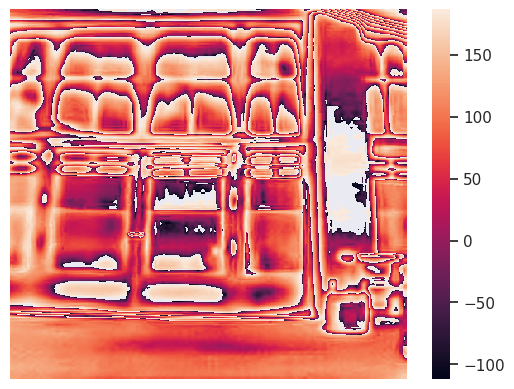

In [ ]:
IRfulltempdifval = im2newtemp('/content/FLIR_20230316_043312_732.jpg')
sns.heatmap(IRfulltempdifval, annot=False, fmt=".2f", xticklabels=False, yticklabels=False)
print(IRfulltempdifval.min())
print(IRfulltempdifval.max())

    1 output files created
The User-set Parameters are the following:
Object Emissivity is 0.95
Reflected Apparent Temperature is 22.00 C
Atmospheric Temperature is 20.00 C
Relative Humidity is 50.00 %
Object distance is 1.00 m


<ipython-input-18-45190c1fa2cd>:94: RuntimeWarning: invalid value encountered in log
  objTemp_C=sensorB/np.log(sensorR/(gGain*(objRawSignal_DN+sensorO))+sensorF)-273.15;


nan
nan


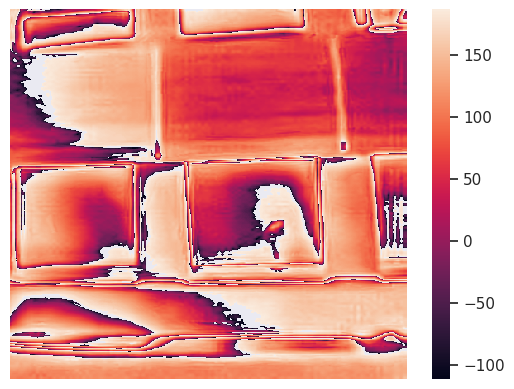

In [ ]:
IRfulltempdifval = im2newtemp('/content/FLIR_20230316_054134_264.jpg')
sns.heatmap(IRfulltempdifval, annot=False, fmt=".2f", xticklabels=False, yticklabels=False)
print(IRfulltempdifval.min())
print(IRfulltempdifval.max())

In [ ]:
myim, mydic = getrawim_data('/content/FLIR_20230316_044057_575.jpg')
# myim, mydic = getrawim_data('/content/Snap-0105.jpg')

print (mydic)

#myim = Image.open('FLIR_20230316_044057_732_test.png', 'r')
width, height = myim.size
pixel_values = list(myim.getdata())
pixel_values = np.array(pixel_values).reshape((height, width))

IRtemp_array = IRcounts2temp(.9, pixel_values)
sns.heatmap(IRtemp_array, annot=False, fmt=".2f", xticklabels=False, yticklabels=False)

print(IRtemp_array.min())
print(IRtemp_array.max())

Output file /content/FLIR_20230316_044057_575.png already exists for /content/FLIR_20230316_044057_575.jpg
    1 files could not be read
    0 output files created


UnidentifiedImageError: cannot identify image file '/content/FLIR_20230316_044057_575.png'

In [ ]:
# impath = '/content/Snap-0105.jpg'
impath = '/content/FLIR_20230316_044057_575.jpg'
# impath = '/content/FLIR_20230316_043312_732.jpg'
tags = !exiftool $impath

# Creating a dictionary from all of the metadata tags
dic = {}
lentags = len(tags)
for i in range(lentags):
    split = tags[i].split(':')
    indexkey = split[0].strip()
    value = split[1].strip()
    dic[indexkey] = value

!exiftool $impath -RawThermalImage -b -w "123.png"
rawim = impath.split('.jpg')
rawim = rawim[0] + '.png'
# rawim = rawim[0] + '.jpg'
im = Image.open(rawim)



    1 output files created


UnidentifiedImageError: cannot identify image file '/content/FLIR_20230316_044057_575.png'

In [ ]:
print(dic)

{'ExifTool Version Number': '12.40', 'File Name': 'FLIR_20230316_044057_575.jpg', 'Directory': '/content', 'File Size': '402 KiB', 'File Modification Date/Time': '2024', 'File Access Date/Time': '2024', 'File Inode Change Date/Time': '2024', 'File Permissions': '-rw-r--r--', 'File Type': 'JPEG', 'File Type Extension': 'jpg', 'MIME Type': 'image/jpeg', 'JFIF Version': '1.01', 'Exif Byte Order': 'Big-endian (Motorola, MM)', 'Image Description': '', 'Make': 'Teledyne FLIR', 'Camera Model Name': 'FLIR ONE Pro (gen 3)', 'Orientation': 'Horizontal (normal)', 'X Resolution': '72', 'Y Resolution': '72', 'Resolution Unit': 'inches', 'Software': 'Flir Cronos', 'Modify Date': '2023', 'Y Cb Cr Positioning': 'Centered', 'Exposure Time': 'undef', 'Exif Version': '0220', 'Create Date': '2023', 'Components Configuration': 'Y, Cb, Cr, -', 'Subject Distance': '1 m', 'Focal Length': '0.0 mm', 'Warning': '[minor] Bad offset for MakerNotes tag 0x0013', 'Flashpix Version': '0100', 'Color Space': 'sRGB', 'Ex

### Temperature Calculation Sensitivity Analysis

In [ ]:
sensitivity_dict = {
    'appReflTemp_C': [ -10, -5, 0, 5, 10],
    'airTemp_C': [-10, -5, 0, 5, 10],
    'airRelHumidity_perc': [65, 70, 75, 80, 85],
    'objDistance_m': [5, 10, 15, 20, 25],
    'objEmissivity': [0.8, 0.85, 0.9, 0.95, 1],
    'rawSignal_DN': [11000]
}

imforsensitivity, dic_ir_im = getrawim_data('Snap-0105.jpg')

sensorR, sensorB, sensorF, sensorO, gGain = getCalParameters(dic_ir_im)

atmAlpha1, atmAlpha2, atmBeta1, atmBeta2, atmX = getAtmParameters(dic_ir_im)

sa = SensitivityAnalyzer(sensitivity_dict, FULLIRcounts2temp)

plot = sa.plot()

styled_dict = sa.styled_dfs()